
# NeuralProphetによる時系列データの予測

> 需要予測パッケージ NeurProphet を紹介する． 


In [ ]:
#default_exp neuralprophetf

In [ ]:
# hide
%reload_ext autoreload
%autoreload 2

In [ ]:
# hide_input
from IPython.display import Image, YouTubeVideo

## NeuralProphetとは

NeuralProphet https://neuralprophet.com/ は需要予測のためのパッケージである． 


In [ ]:
# インストールされていない場合には、以下を生かす。
# !pip install -U neuralprophet
# !pip install -U vega_datasets
# !pip install -U ipywidgets

## 諸パッケージのインポート

NeuralProphetで予測するために必要なパッケージをインポートしておく． vega_datasetsのデータを用いるので，インストールしておく．

https://github.com/altair-viz/vega_datasets

In [ ]:
# export
import pandas as pd
from neuralprophet import NeuralProphet, set_log_level

# Disable logging messages unless there is an error
set_log_level("ERROR")

from vega_datasets import data
import plotly.express as px
import plotly

## NeuralProphetの基本

NeuralProphetをPythonから呼び出して使う方法は，機械学習パッケージscikit-learnと同じである。


1.   **NeuralProphet**クラスのインスタンス**model**を生成
2.   **fit**メソッドで学習（引数はデータフレーム）
3.   **predict**メソッドで予測（引数は予測したい期間を含んだデータフレーム）

### 例題：Wikiアクセス数

例としてアメリカンフットボールプレーヤのPayton ManningのWikiアクセス数のデータを用いる。

In [ ]:
df = pd.read_csv("http://logopt.com/data/peyton_manning.csv")
df.head()

ds         y
0  2007-12-10  9.590761
1  2007-12-11  8.519590
2  2007-12-12  8.183677
3  2007-12-13  8.072467
4  2007-12-14  7.893572

Prophetモデルのインスタンスを生成し，fitメソッドで学習（パラメータの最適化）を行う．fitメソッドに渡すのは，上で作成したデータフレームである．このとき、**ds**(datestamp)列に日付（時刻）を、**y**列に予測したい数値を入れておく必要がある
（この例題では，あらかじめそのように変更されている）．


In [ ]:
# Create a NeuralProphet model with default parameters
model = NeuralProphet()
# Use static plotly in notebooks
model.set_plotting_backend("matplotlib")

model.fit(df)

WARNING - (py.warnings._showwarnmsg) - /Users/mikiokubo/Library/Caches/pypoetry/virtualenvs/analytics2-0ZiTWol9-py3.9/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

Missing logger folder: /Users/mikiokubo/Documents/dev/analytics2/nbs/lightning_logs


Finding best initial lr:   0%|          | 0/236 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

MAE      RMSE      Loss  RegLoss  epoch
0    5.459767  6.524359  0.618205      0.0      0
1    5.107094  6.143243  0.561208      0.0      1
2    4.644974  5.626804  0.487217      0.0      2
3    4.000104  4.899981  0.387323      0.0      3
4    3.147719  3.894842  0.261640      0.0      4
..        ...       ...       ...      ...    ...
137  0.346690  0.483465  0.004732      0.0    137
138  0.347521  0.481591  0.004706      0.0    138
139  0.347404  0.482274  0.004701      0.0    139
140  0.347216  0.484352  0.004701      0.0    140
141  0.347227  0.484229  0.004702      0.0    141

[142 rows x 5 columns]

**make_future_dataframe**メソッドで未来の時刻を表すデータフレームを生成する。既定値では、予測で用いた過去の時刻も含む。
引数は予測をしたい期間数**periods**であり，ここでは、１年後（365日分）まで予測することにする。

Predicting: 91it [00:00, ?it/s]

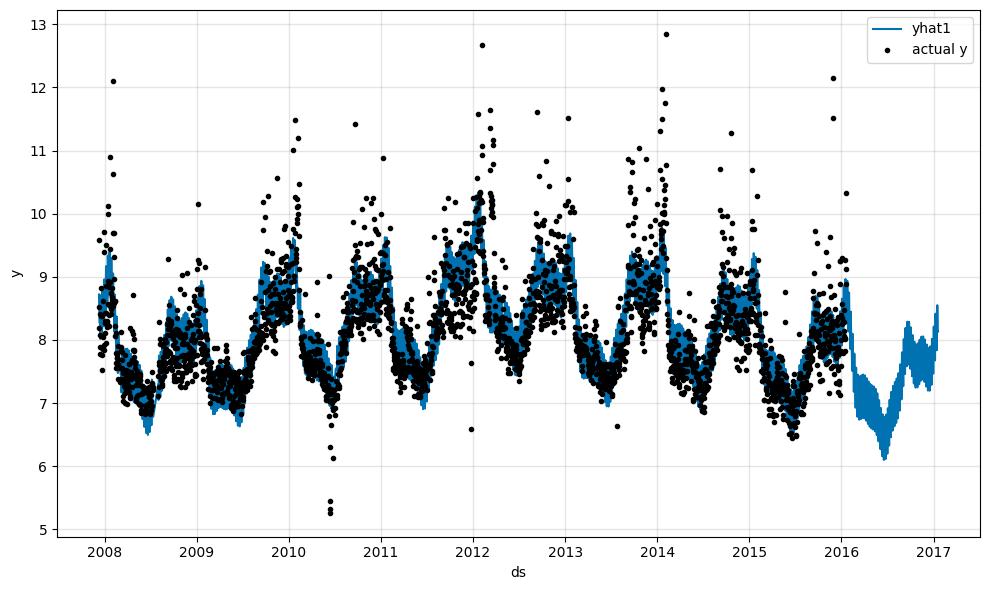

In [ ]:
df_future = model.make_future_dataframe(df, n_historic_predictions=True, periods=365)
forecast = model.predict(df_future)
model.plot(forecast)
#plotly.offline.plot(fig);

predict メソッドに予測したい時刻を含んだデータフレームfuture を渡すと、予測値を入れたデータフレームforecastを返す。

In [ ]:
forecast.tail()

ds   y     yhat1     trend  season_yearly  season_weekly
3265 2017-01-15 NaN  8.216602  7.137280       1.036658       0.042665
3266 2017-01-16 NaN  8.550267  7.136175       1.049828       0.364264
3267 2017-01-17 NaN  8.316690  7.135070       1.060175       0.121446
3268 2017-01-18 NaN  8.133187  7.133965       1.067564      -0.068342
3269 2017-01-19 NaN  8.133450  7.132861       1.071885      -0.071296

### 一般化加法モデル

Prophetにおける予測は**一般化加法モデル**を用いて行われる．これは，傾向変動，季節変動，イベント情報などの様々な因子の和として予測を行う方法である．

$$
 y_t =g_t + s_t + h_t + \epsilon_t 
$$

- $y_t$ : 予測値
- $g_t$ : 傾向変動(trend)；傾向変化点ありの線形もしくはロジスティック曲線
- $s_t$ : 季節変動；年次，週次，日次の季節変動をsin, cosの組み合わせ（フーリエ級数）で表現
- $h_t$ : 休日などのイベント項
- $\epsilon_t$ : 誤差項


因子ごとに予測値の描画を行うには，plot_componentsメソッドを用いる．既定では，以下のように，上から順に傾向変動，週次の季節変動，年次の季節変動が描画される．また，傾向変動の図（一番上）には，予測の誤差範囲が示される．季節変動の誤差範囲を得る方法については，後述する．


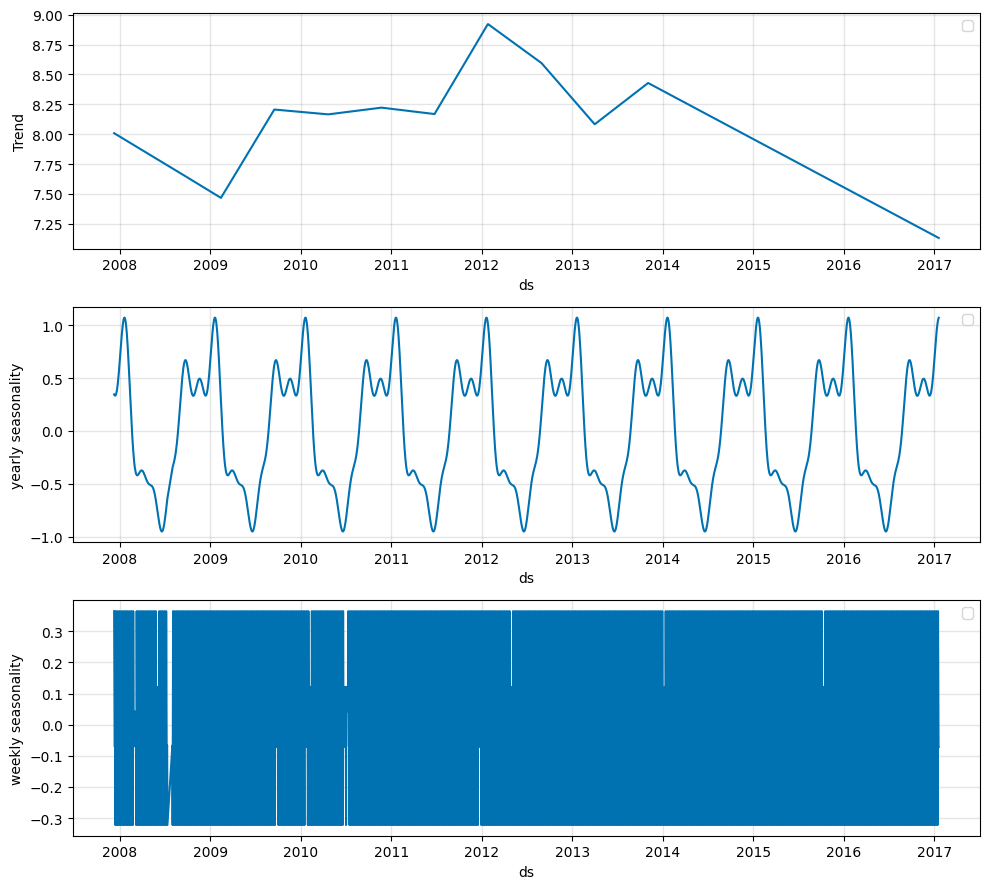

In [ ]:
model.plot_components(forecast)
#plotly.offline.plot(fig2);

対話形式に，拡大縮小や範囲指定ができる動的な図も，Plotlyライブラリを用いて得ることができる．

In [ ]:
fig = fp.plot_plotly(model, forecast) 
plotly.offline.plot(fig);

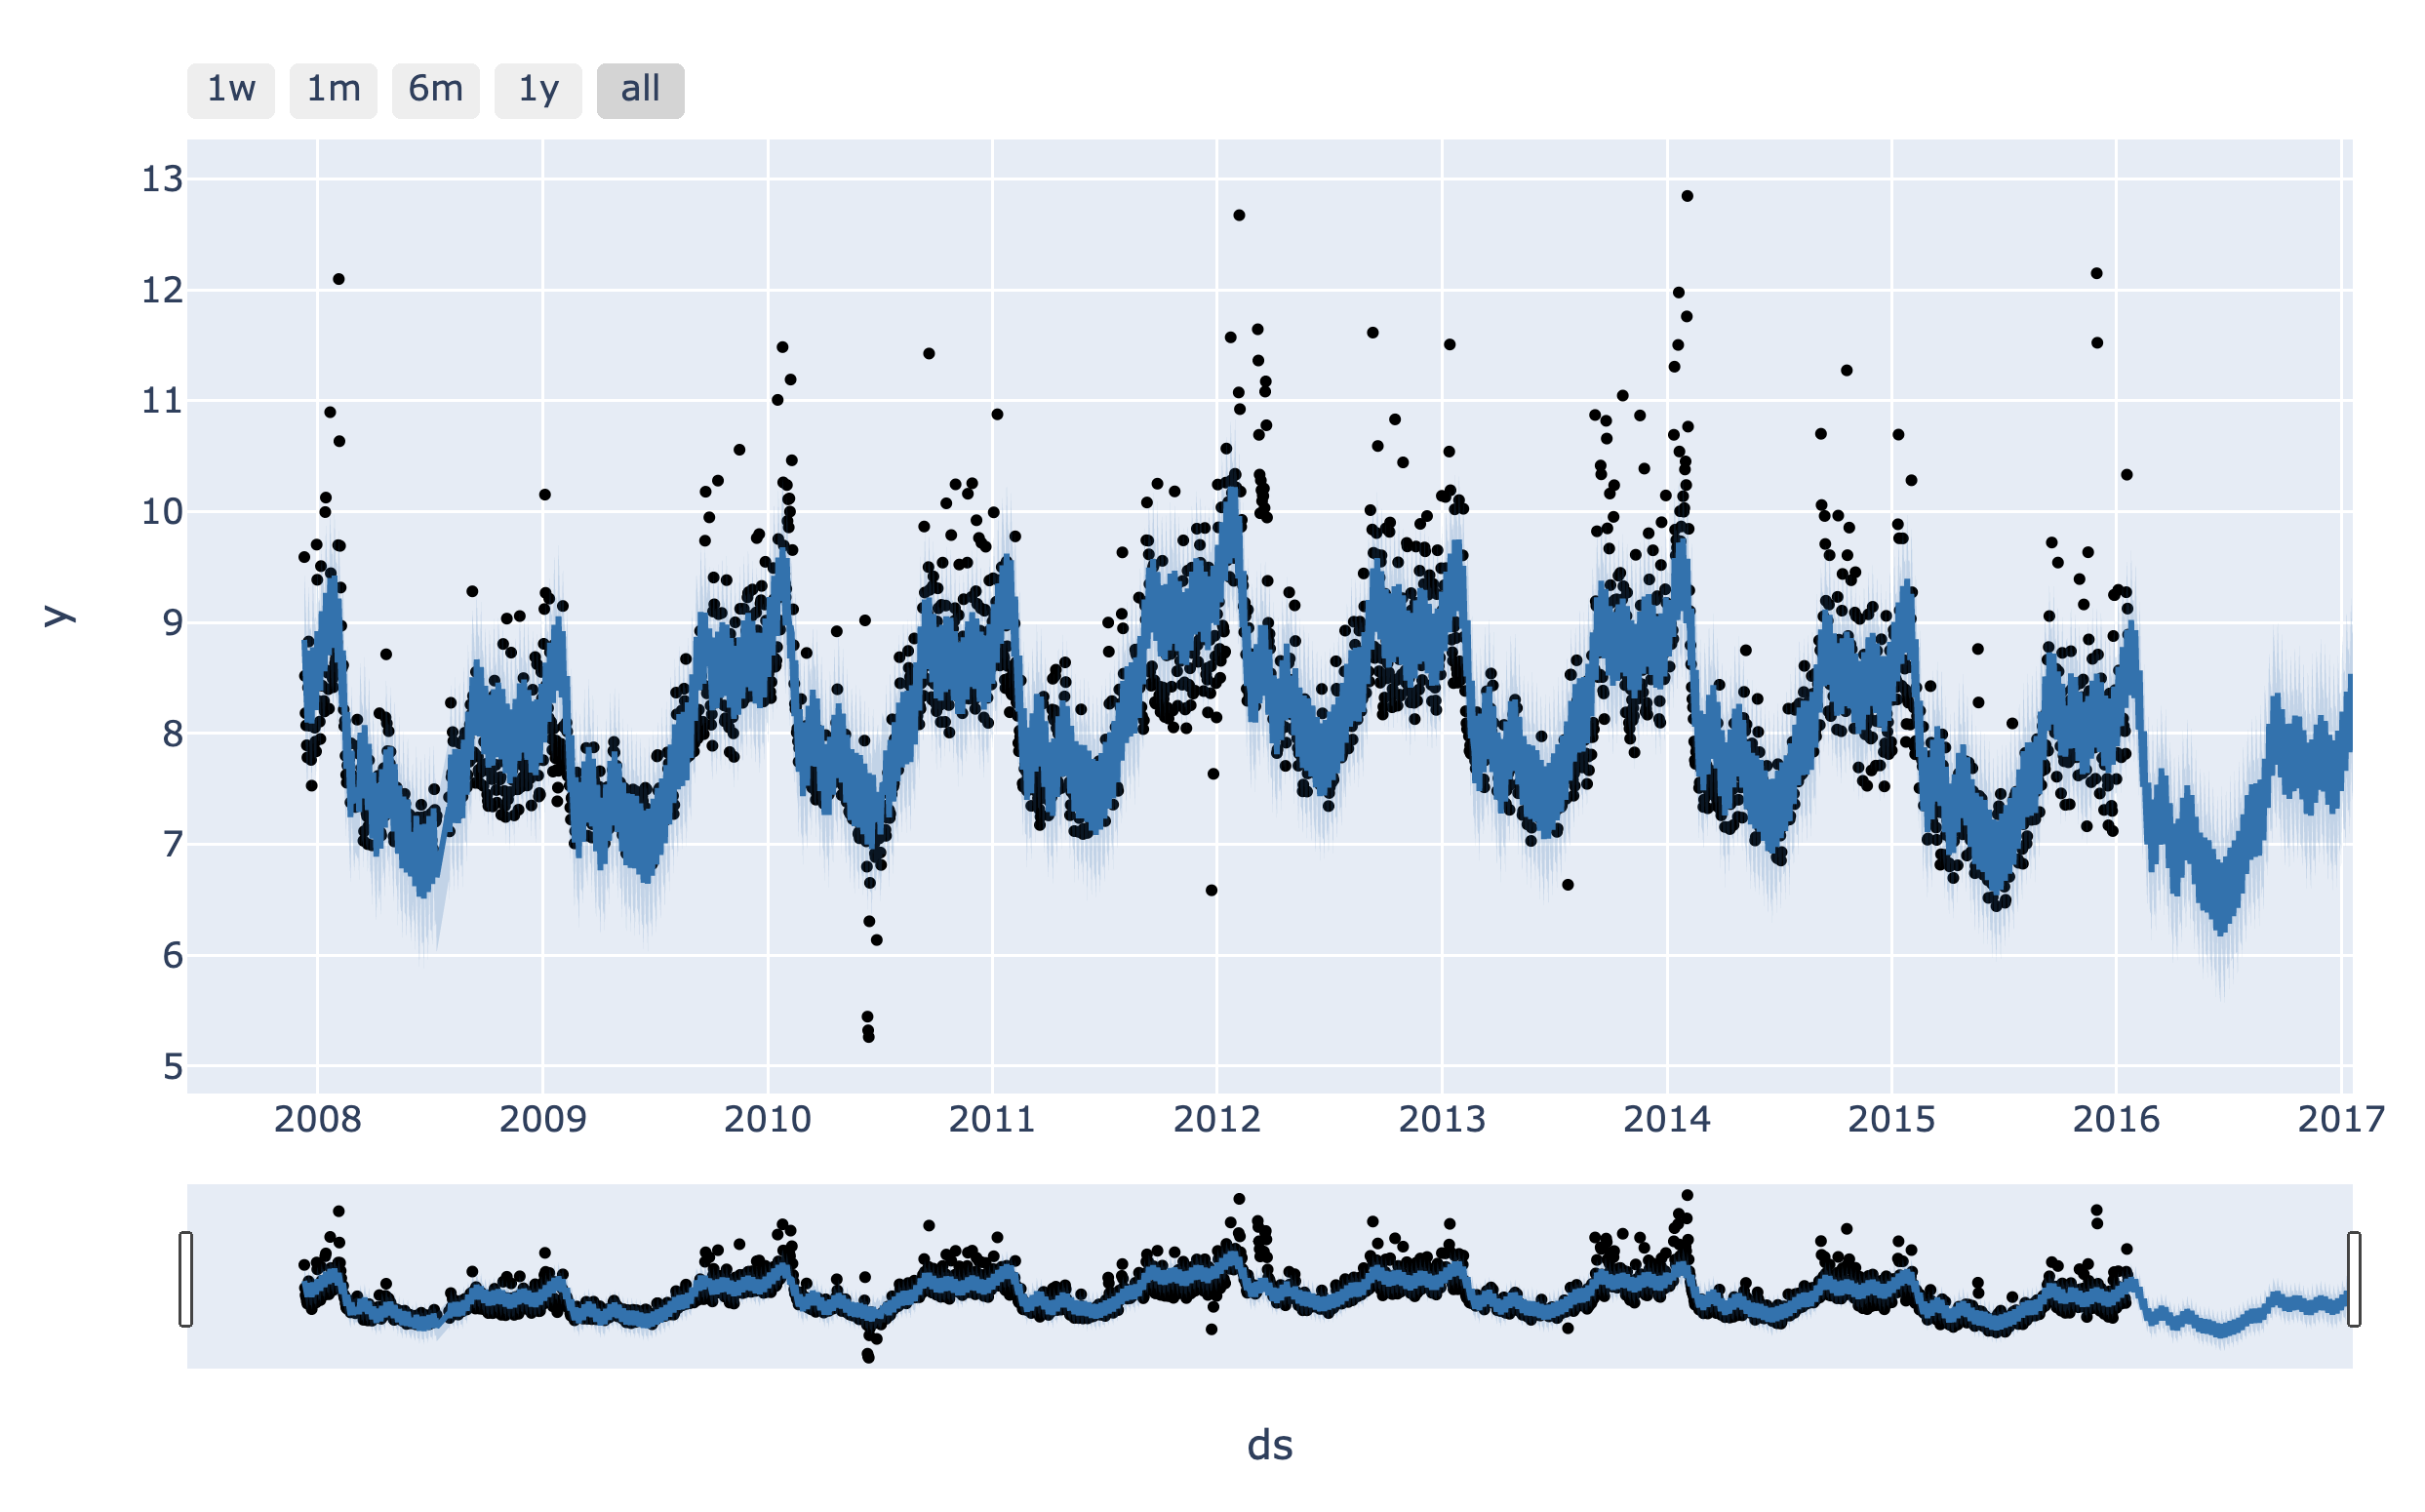

In [ ]:
# hide_input
Image("../figure/prophet1.PNG", width=700, height=400)

###  例題： $CO_2$ 排出量のデータ

データライブラリから二酸化炭素排出量のデータを読み込み，Plotly Expressで描画する．

In [ ]:
co2 = data.co2_concentration()
co2.head()

Date     CO2
0  1958-03-01  315.70
1  1958-04-01  317.46
2  1958-05-01  317.51
3  1958-07-01  315.86
4  1958-08-01  314.93

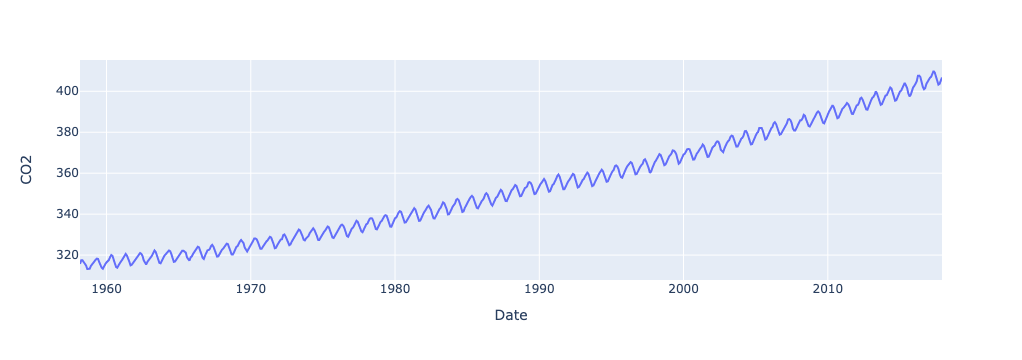

In [ ]:
fig = px.line(co2,x="Date",y="CO2")
plotly.offline.plot(fig);

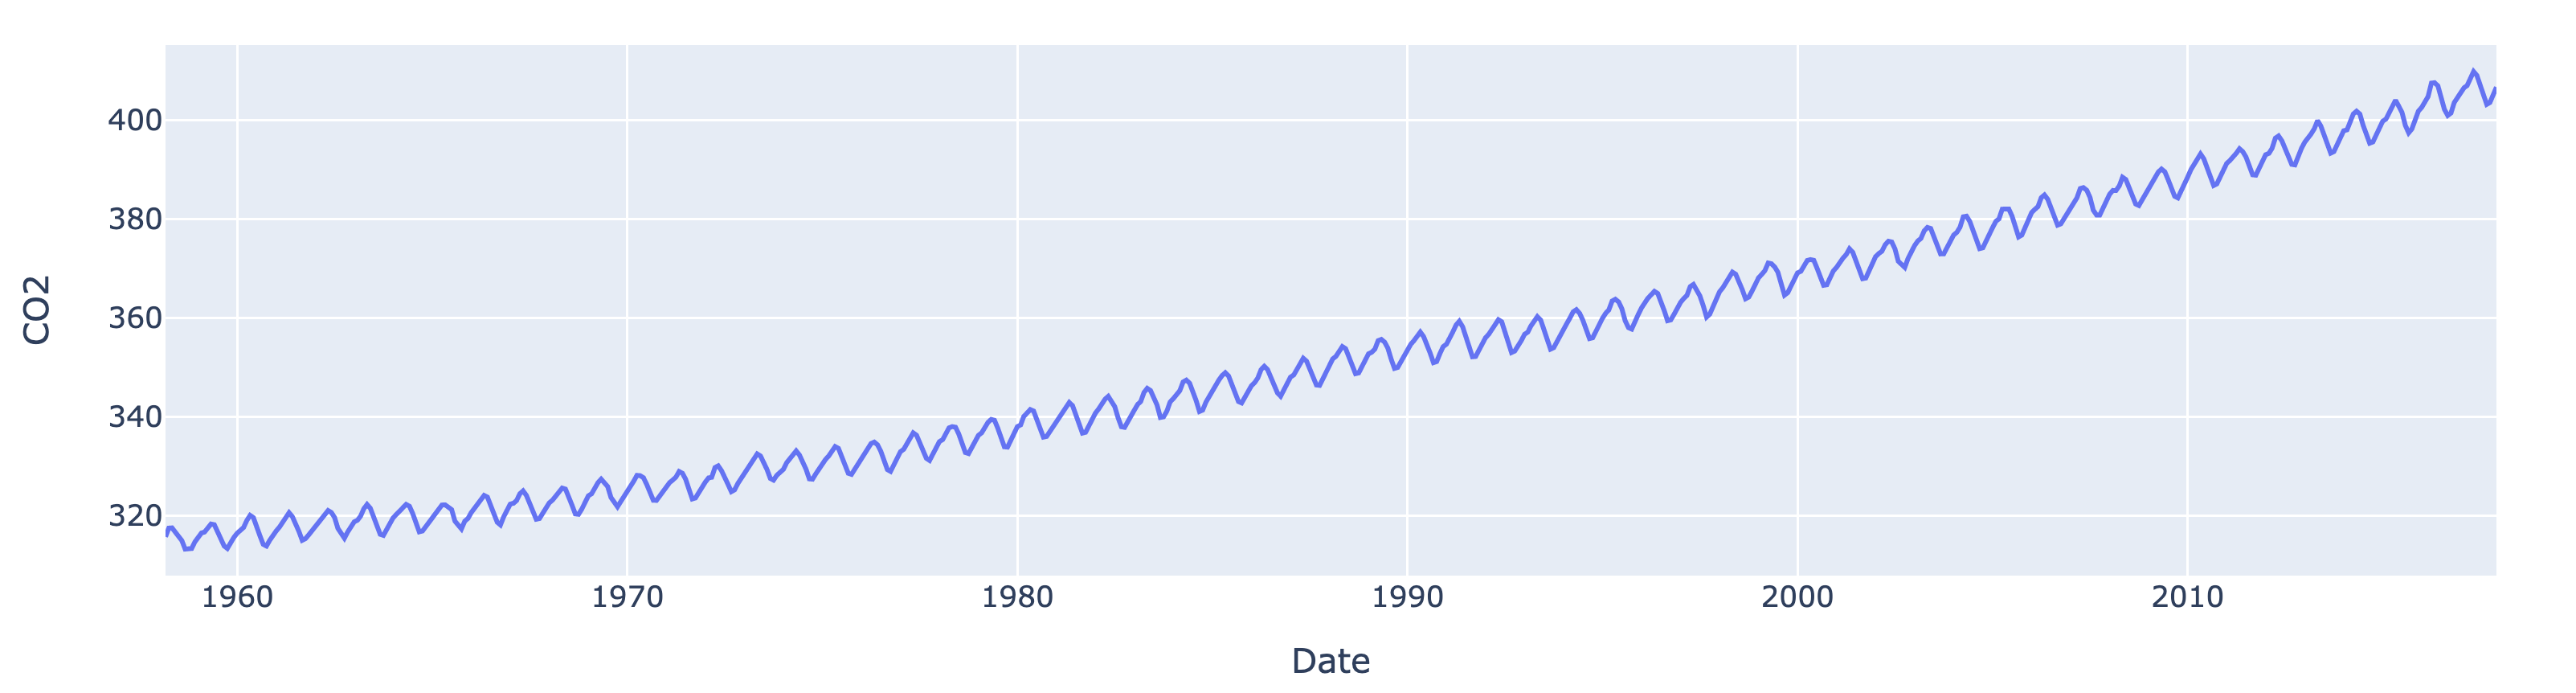

In [ ]:
# hide_input
Image("../figure/prophet2.PNG", width=700, height=400)


列名の変更には，データフレームの**rename**メソッドを用いる．引数は**columns**で，元の列名をキーとし，変更後の列名を値とした辞書を与える．また，元のデータフレームに上書きするために，**inplace**引数を**True**に設定しておく．

In [ ]:
co2.rename(columns={"Date":"ds","CO2":"y"},inplace=True)
co2.head()

ds       y
0  1958-03-01  315.70
1  1958-04-01  317.46
2  1958-05-01  317.51
3  1958-07-01  315.86
4  1958-08-01  314.93

**make_future_dataframe**メソッドで未来の時刻を表すデータフレームを生成する。既定値では、（予測で用いた）過去の時刻も含む。
ここでは、200ヶ月先まで予測することにする。

そのために，引数 **periods** を200に，頻度を表す引数 **freq** をMonthを表す **M** に設定しておく

predict メソッドに予測したい時刻を含んだデータフレームfuture を渡すと、予測値を入れたデータフレームforecastを返す。このデータフレームは、予測値yhatの他に、予測の幅などの列を含む。

最後にplotメソッドで表示する．

09:49:04 - cmdstanpy - INFO - Chain [1] start processing
09:49:04 - cmdstanpy - INFO - Chain [1] done processing


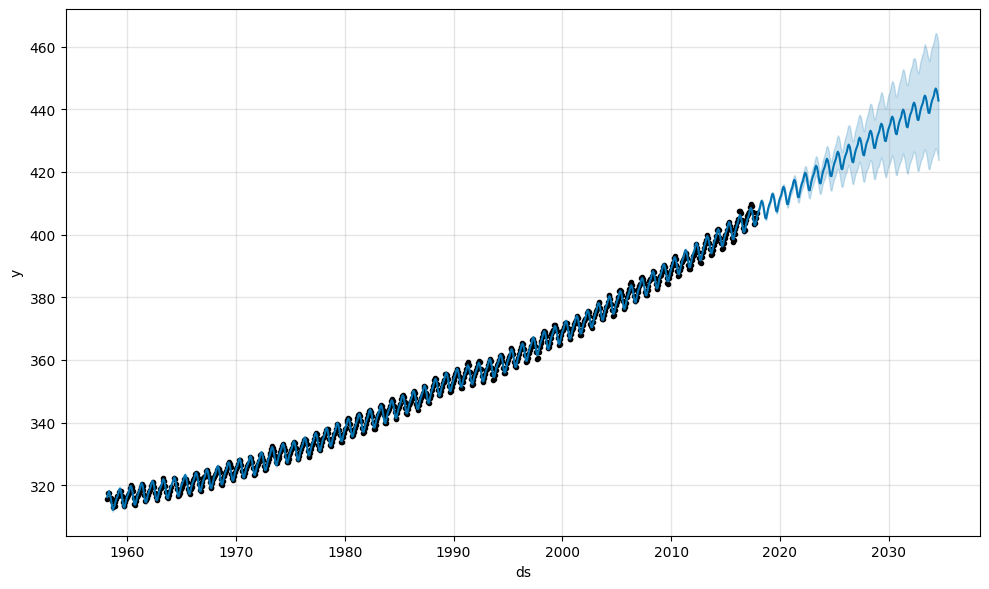

In [ ]:
model = Prophet()
model.fit(co2)
future = model.make_future_dataframe(periods=200, freq=`M`)
forecast = model.predict(future)
model.plot(forecast);

予測は一般化加法モデルを用いて行われる．

これは，傾向変動，季節変動，イベント情報などの様々な因子の和として予測を行う方法である．

上に表示されているように，週次と日次の季節変動は無視され，年次の季節変動のみ考慮して予測している．


因子ごとに予測値の描画を行うには，plot_componentsメソッドを用いる．既定では，以下のように，上から順に傾向変動，週次の季節変動，年次の季節変動が描画される．また，傾向変動の図（一番上）には，予測の誤差範囲が示される．季節変動の誤差範囲を得る方法については，後述する．

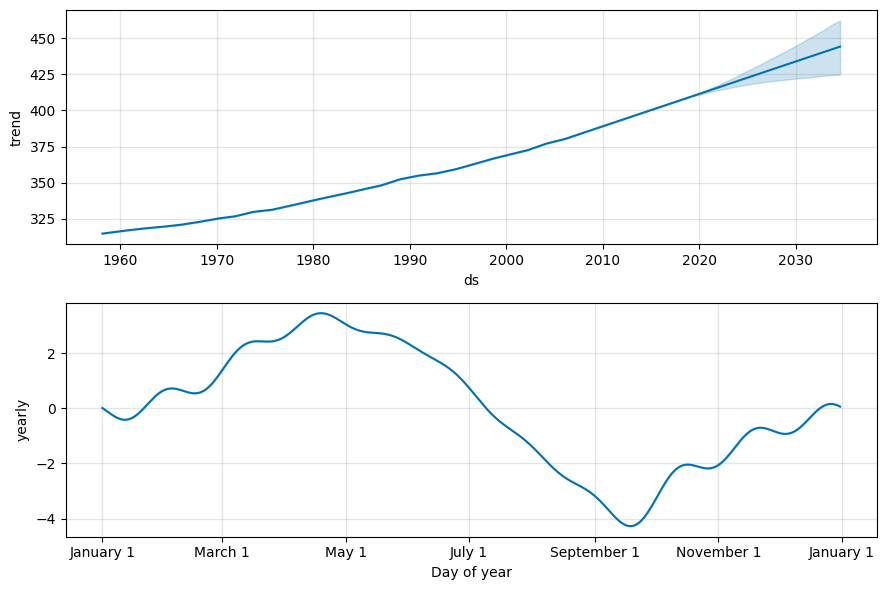

In [ ]:
model.plot_components(forecast);

Plotlyで描画すると， 一部を拡大，期の選択などが可能になる．

In [ ]:
fig = fp.plot_plotly(model, forecast)
plotly.offline.plot(fig);

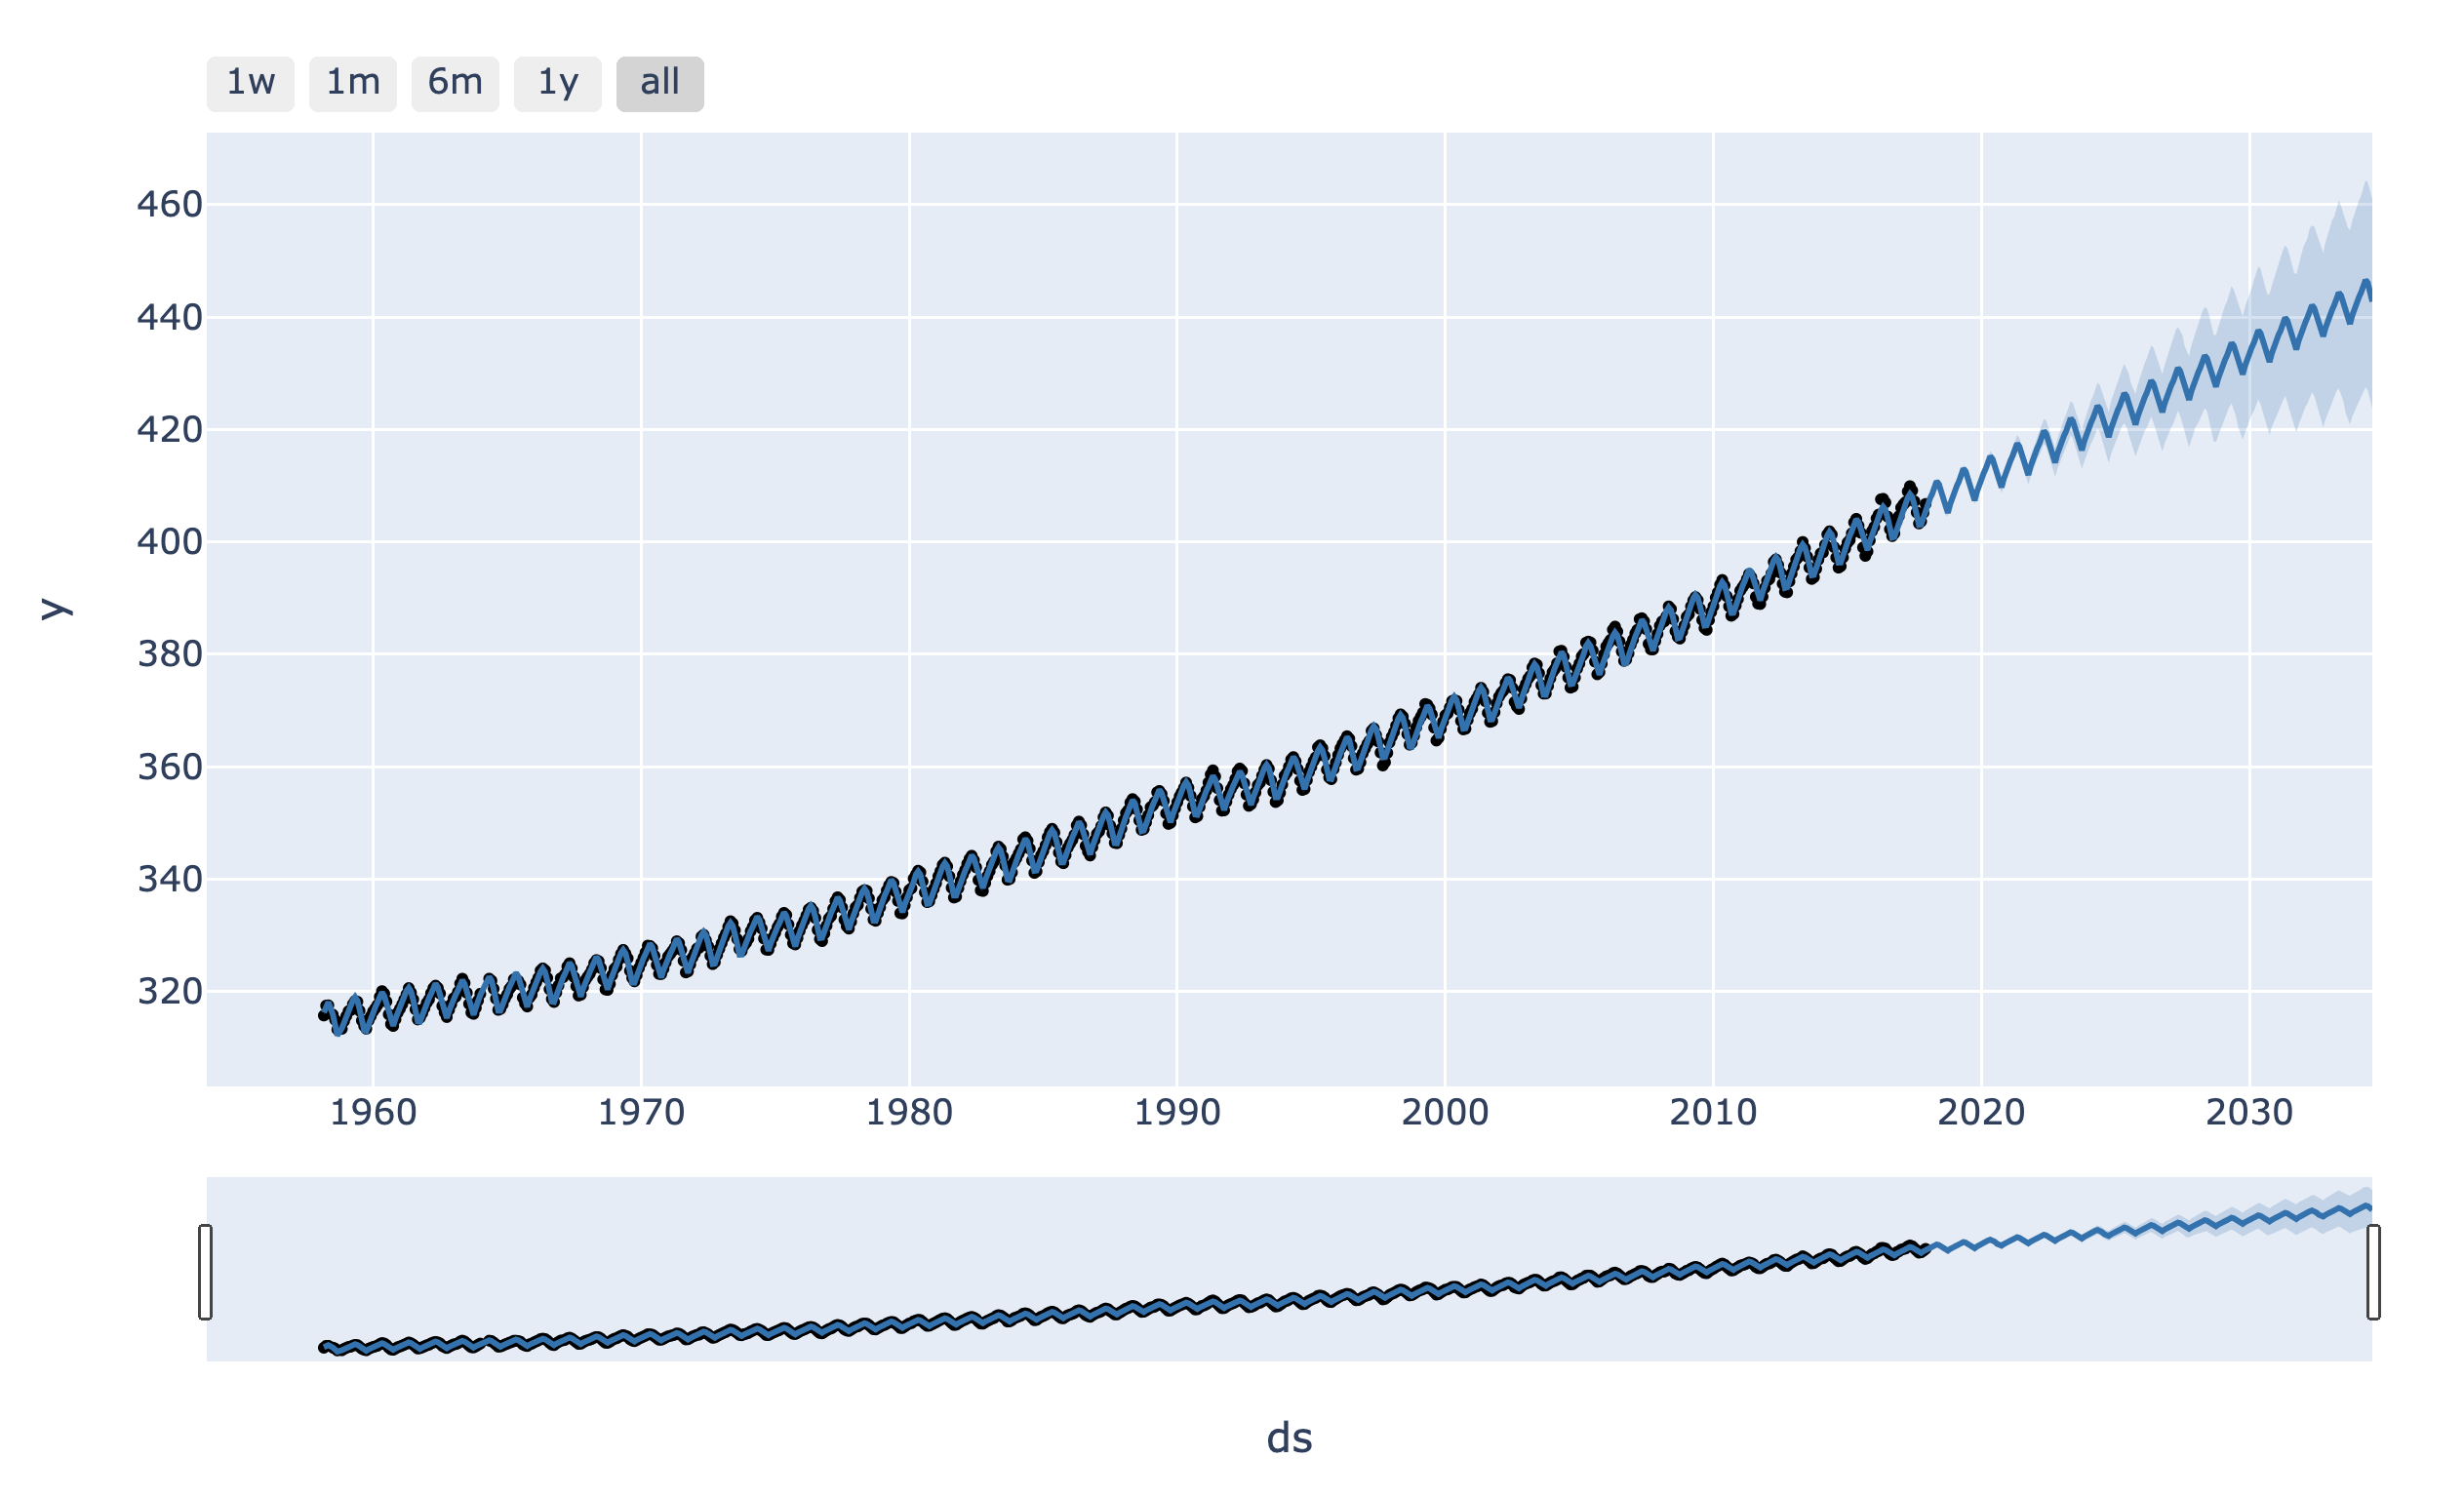

In [ ]:
# hide_input
Image("../figure/prophet3.PNG", width=700, height=400)

### 例題：航空機乗客数のデータ

Prophetの既定値では季節変動は加法的モデルであるが、問題によっては乗法的季節変動の方が良い場合もある。
例として、航空機の乗客数を予測してみよう。最初に既定値の加法的季節変動モデルで予測し，次いで乗法的モデルで予測する．

In [ ]:
passengers = pd.read_csv("http://logopt.com/data/AirPassengers.csv")
passengers.head()

Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121

In [ ]:
fig = px.line(passengers,x="Month",y="#Passengers")
plotly.offline.plot(fig);

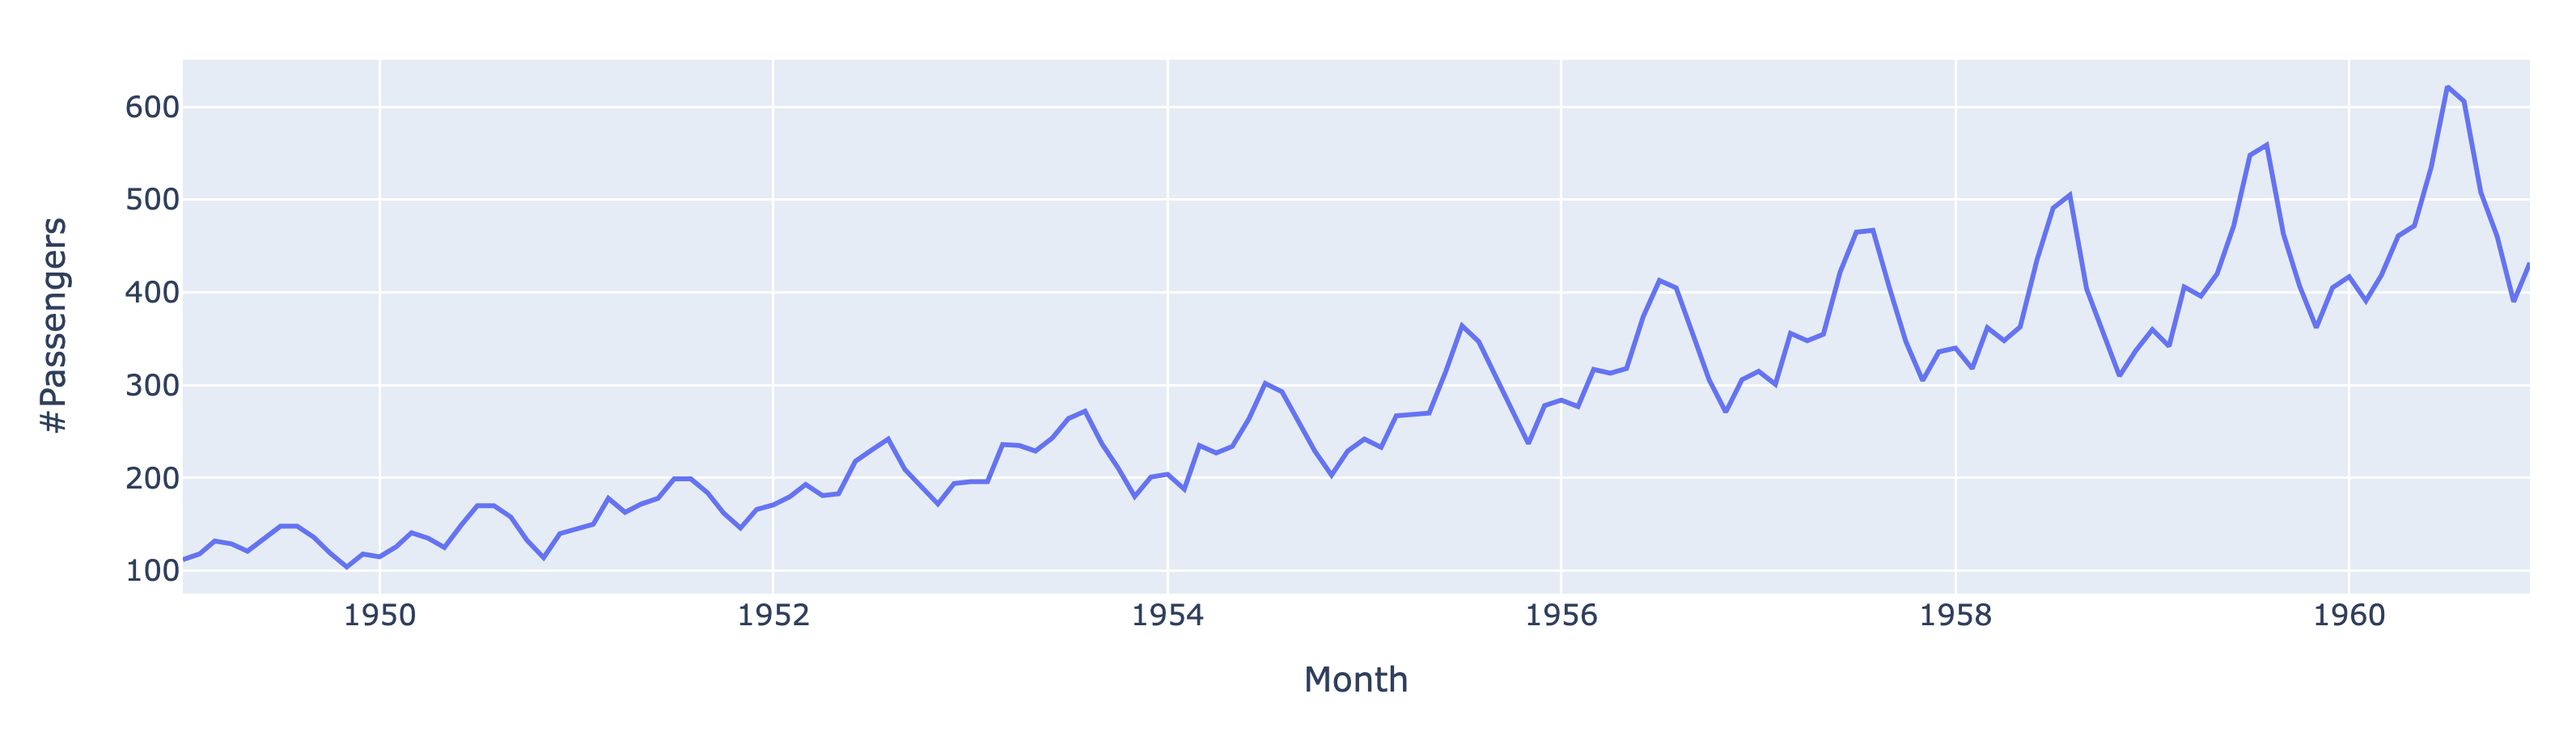

In [ ]:
# hide_input
Image("../figure/prophet4.PNG", width=700, height=400)

In [ ]:
passengers.rename(inplace=True,columns={"Month":"ds","#Passengers":"y"})
passengers.head()

ds    y
0  1949-01  112
1  1949-02  118
2  1949-03  132
3  1949-04  129
4  1949-05  121


季節変動を乗法的に変更するには， モデルの **seasonality_mode** 引数を乗法的を表す **multiplicative** に設定する．

なお，以下のデータは月次のデータであるので，make_future_dataframeの **freq** 引数を **M** (Month)に設定する．

09:58:45 - cmdstanpy - INFO - Chain [1] start processing
09:58:45 - cmdstanpy - INFO - Chain [1] done processing


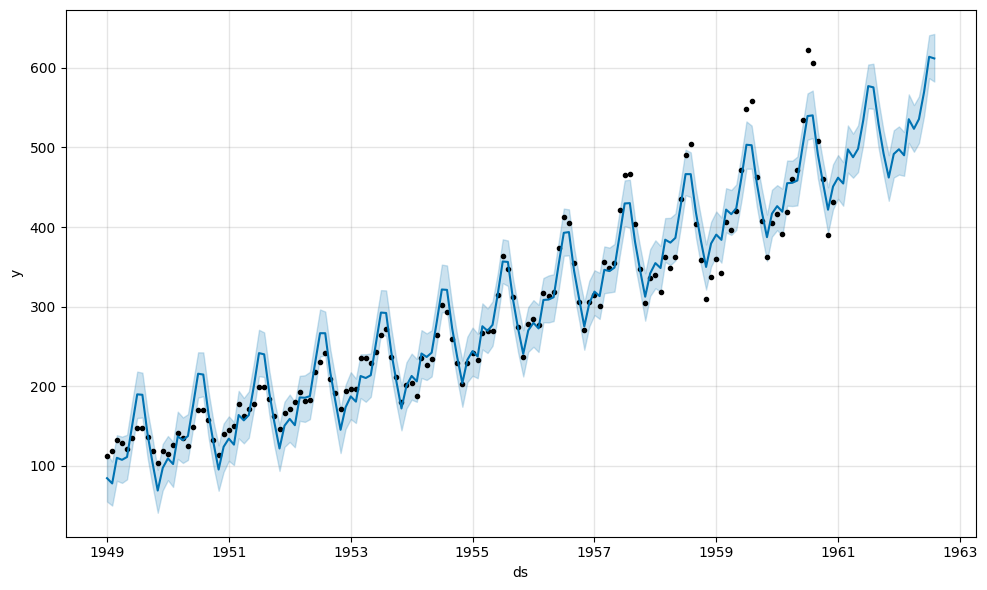

In [ ]:
model = Prophet().fit(passengers)
future = model.make_future_dataframe(periods=20, freq="M")
forecast = model.predict(future)
model.plot(forecast);

09:56:17 - cmdstanpy - INFO - Chain [1] start processing
09:56:17 - cmdstanpy - INFO - Chain [1] done processing


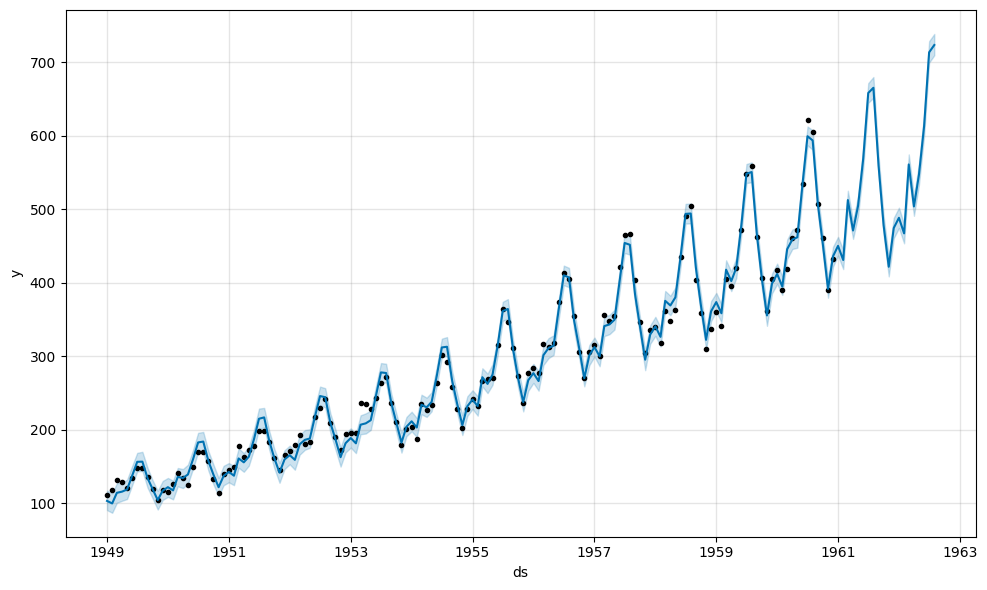

In [ ]:
model = Prophet(seasonality_mode="multiplicative").fit(passengers)
future = model.make_future_dataframe(periods=20, freq="M")
forecast = model.predict(future)
model.plot(forecast);

結果から，乗法的季節変動の方が，良い予測になっていることが確認できる．

In [ ]:
#hide
#model.plot_components(forecast);

### 問題（小売りの需要データ）

以下の，小売りの需要データを描画し，予測を行え．
ただし，モデルは乗法的季節変動で，月次で予測せよ．

In [ ]:
retail = pd.read_csv(`http://logopt.com/data/retail_sales.csv`)
retail.head()

ds       y
0  1992-01-01  146376
1  1992-02-01  147079
2  1992-03-01  159336
3  1992-04-01  163669
4  1992-05-01  170068

In [ ]:
#export
# retail = pd.read_csv(`http://logopt.com/data/retail_sales.csv`)
# model = Prophet(seasonality_mode=`multiplicative`).fit(retail)
# future = model.make_future_dataframe(periods=20, freq=`M`)
# forecast = model.predict(future)
# model.plot(forecast);
# #model.plot_components(forecast);

### 例題： 1時間ごとの気温データ

ここではシアトルの気温の予測を行う．


In [ ]:
climate = data.seattle_temps()
climate.head()

date  temp
0 2010-01-01 00:00:00  39.4
1 2010-01-01 01:00:00  39.2
2 2010-01-01 02:00:00  39.0
3 2010-01-01 03:00:00  38.9
4 2010-01-01 04:00:00  38.8

このデータは， **date** 列に日付と1時間ごとの時刻が， **temp** 列に気温データが入っている．

Prophetは， 日別でないデータも扱うことができる。 date列のデータ形式は、日付を表す`YYYY-MM-DD`の後に時刻を表す`HH:MM:SS`が追加されている。
未来の時刻を表すデータフレームは、`make_future_dataframe`メソッドで生成するが、このとき引数`freq`で時間の刻みを指定する。 
ここでは1時間を表す **H** を指定する。

In [ ]:
climate["Date"] = pd.to_datetime(climate.date)

In [ ]:
climate.rename(columns={"Date":"ds","temp":"y"},inplace=True)

10:06:08 - cmdstanpy - INFO - Chain [1] start processing
10:06:11 - cmdstanpy - INFO - Chain [1] done processing


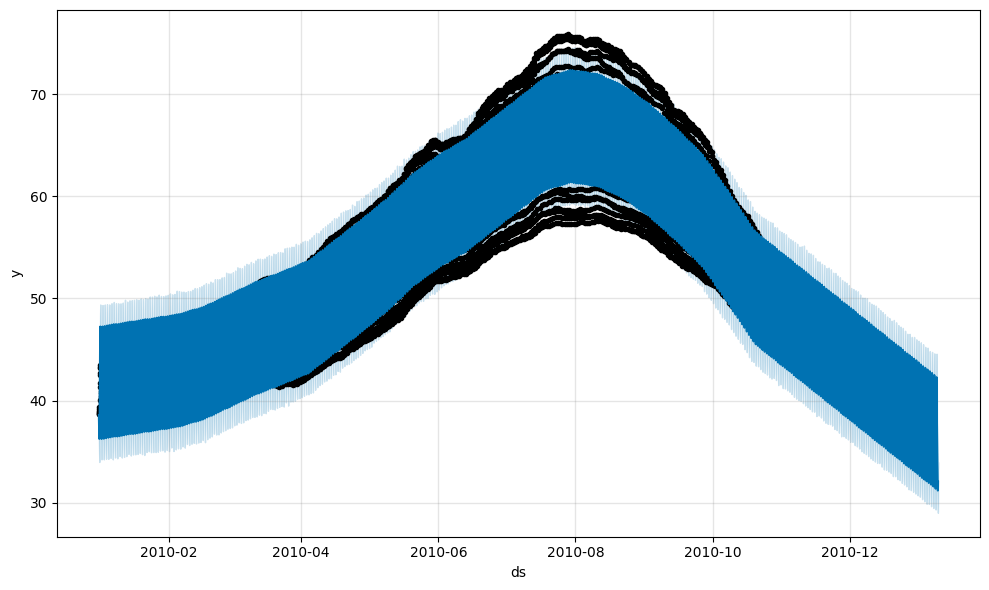

In [ ]:
model = Prophet().fit(climate)
future = model.make_future_dataframe(periods=200, freq="H")
forecast = model.predict(future)
model.plot(forecast);

因子ごとに予測値を描画すると，傾向変動と週次の季節変動の他に，日次の季節変動（1日の気温の変化）も出力される．

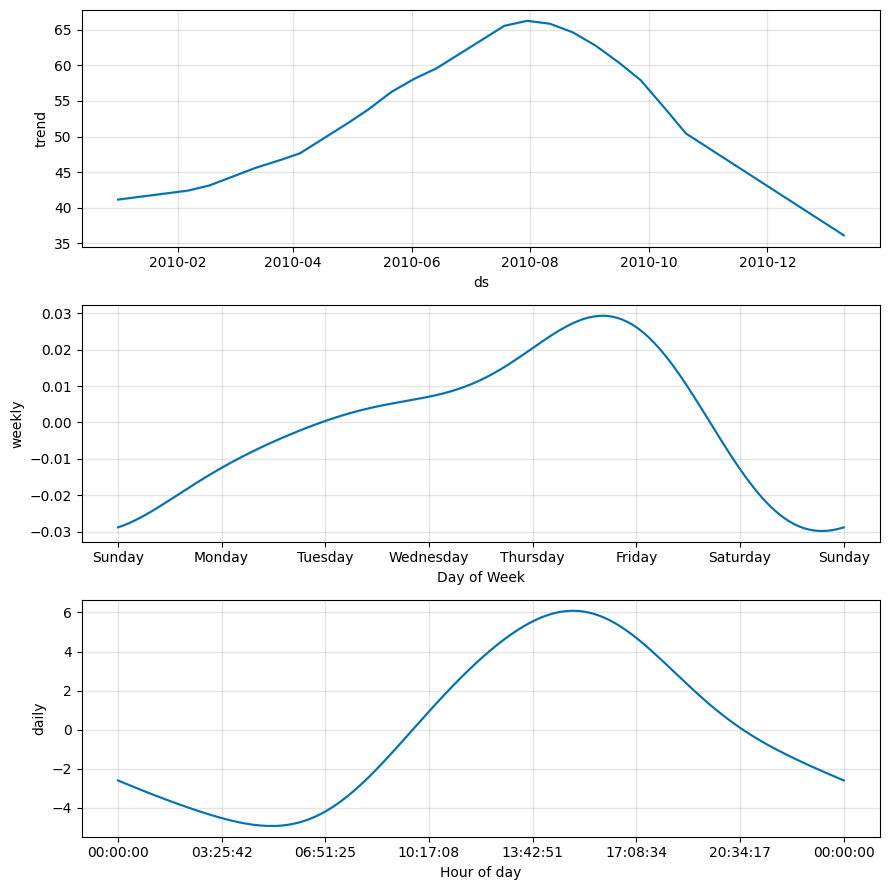

In [ ]:
model.plot_components(forecast);

### 問題（サンフランシスコの気温データ）

以下のサンフランシスコの気温データを描画し，時間単位で予測を行え．

In [ ]:
sf = data.sf_temps()
sf.head()

temp                date
0  47.8 2010-01-01 00:00:00
1  47.4 2010-01-01 01:00:00
2  46.9 2010-01-01 02:00:00
3  46.5 2010-01-01 03:00:00
4  46.0 2010-01-01 04:00:00

In [ ]:
#export
# sf = data.sf_temps()
# sf["Date"] = pd.to_datetime(sf.date)
# sf.rename(columns={"Date":"ds","temp":"y"},inplace=True)
# model = Prophet().fit(sf)
# future = model.make_future_dataframe(periods=200, freq=`H`)
# forecast = model.predict(future)
# model.plot(forecast);

#hide
<!-- ## 例題 Githubのアクセス数データ

誤差が正規分布でない場合の取り扱い． -->

In [ ]:
#hide
github = data.github()
github.tail()

time  count
950 2015-05-29 17:00:00      1
951 2015-05-29 19:00:00      1
952 2015-05-30 00:00:00     10
953 2015-05-30 09:00:00      1
954 2015-05-30 11:00:00      2

In [ ]:
#hide
# fig = px.line(github,x="time",y="count")
# plotly.offline.plot(fig);

#hide

<!-- ### 累積量を計算

**cumsum**で累積和（cumulative sum）が計算できる．

これを用いて予測する．


誤差が正規分布に近いことが確認できる．

他の方法（予測したいものの対数をとるなどの方法）だとうまくいかない． -->

In [ ]:
#hide
#github["cumsum"] = np.log(github["count"]+0.1)
github["cumsum"] = github["count"].cumsum()
github.rename(inplace=True,columns={"time":"ds","cumsum":"y"})
github.head()

ds  count   y
0 2015-01-01 01:00:00      2   2
1 2015-01-01 04:00:00      3   5
2 2015-01-01 05:00:00      1   6
3 2015-01-01 08:00:00      1   7
4 2015-01-01 09:00:00      3  10

11:20:22 - cmdstanpy - INFO - Chain [1] start processing
11:20:22 - cmdstanpy - INFO - Chain [1] done processing


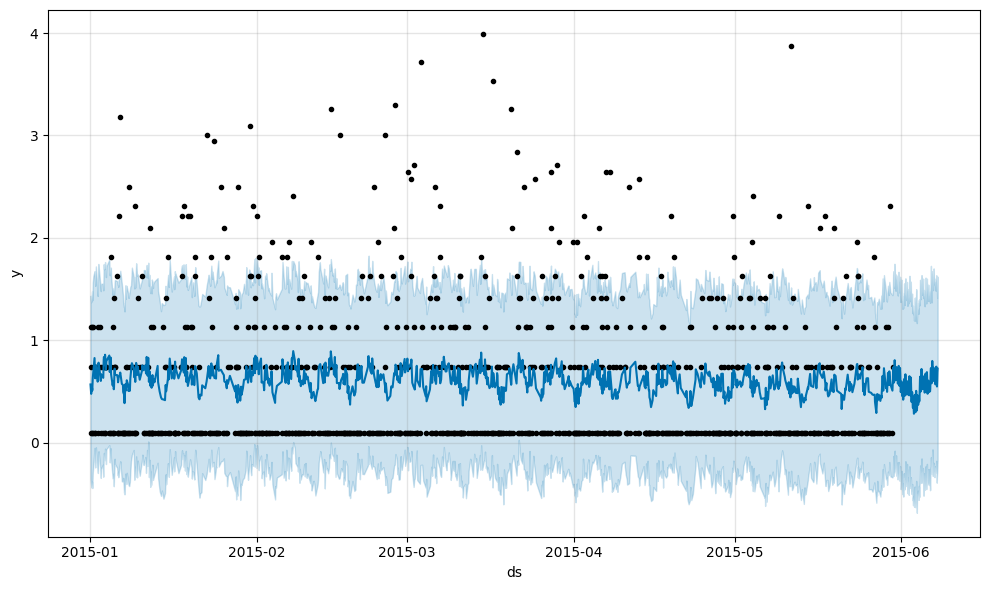

In [ ]:
#hide
model = Prophet().fit(github)
future = model.make_future_dataframe(periods=200, freq="H")
forecast = model.predict(future)
model.plot(forecast);
model.plot_components(forecast);

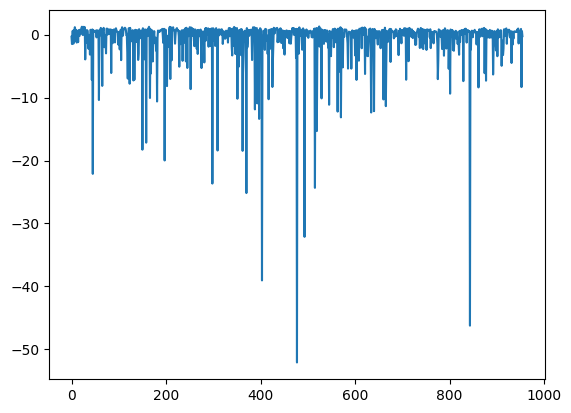

In [ ]:
#hide
#forecast["error"] = np.exp(forecast.yhat)-np.exp(github.y)
# forecast["error"] = forecast.yhat - github.y
forecast["error"].plot();

### 傾向変化点

「上昇トレンドの株価が，下降トレンドに移った」というニュースをよく耳にするだろう．このように，傾向変動は，時々変化すると仮定した方が自然なのだ．Prophetでは，これを傾向の変化点として処理する．再び，Peyton Manningのデータを使う．

add_changepoints_to_plotを使うと、変化した点（日次）と傾向変動を図に追加して描画できる。引数は軸(axis)，モデル(model)，予測データフレーム(forecast)であり，
軸は図オブジェクトのgca(get current axis)メソッドで得る．

11:27:07 - cmdstanpy - INFO - Chain [1] start processing
11:27:08 - cmdstanpy - INFO - Chain [1] done processing


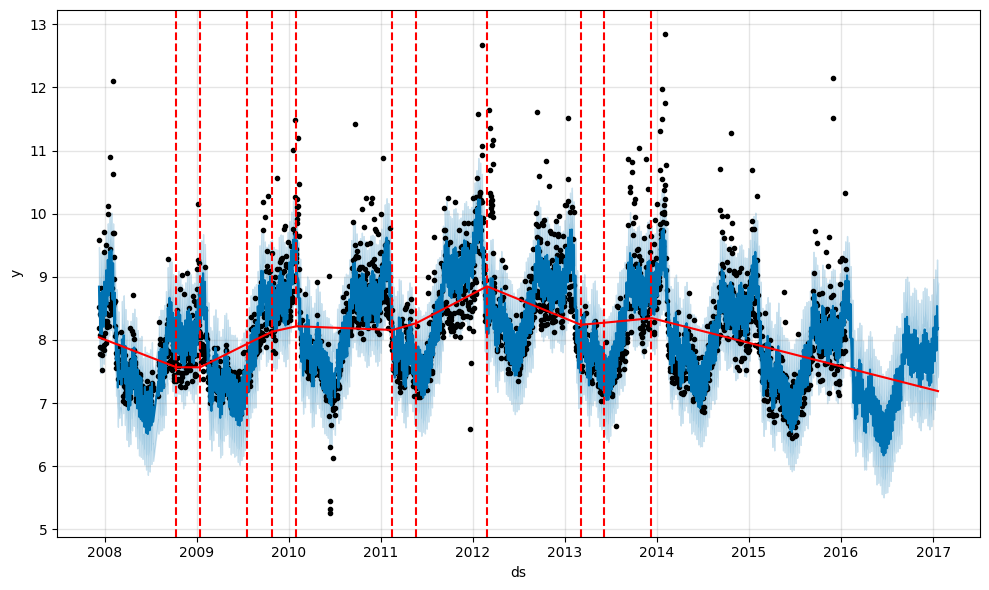

In [ ]:
df = pd.read_csv(`http://logopt.com/data/peyton_manning.csv`)
model = Prophet().fit(df)
future = model.make_future_dataframe(periods=366)
forecast = model.predict(future)
fig = model.plot(forecast)
a = fp.add_changepoints_to_plot(fig.gca(),model,forecast);

変化点の数を制御するための引数は **changepoint_prior_scale** であり、既定値は $0.05$ である。これを増やすと変化点が増え、予測の自由度が増すため予測幅が大きくなる。

11:28:49 - cmdstanpy - INFO - Chain [1] start processing
11:28:51 - cmdstanpy - INFO - Chain [1] done processing


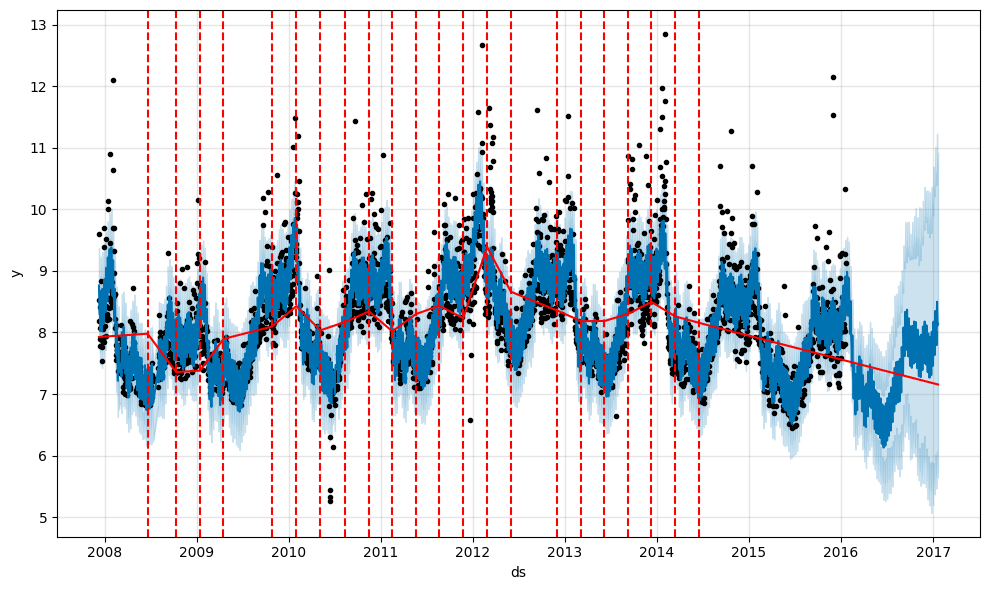

In [ ]:
model = Prophet(changepoint_prior_scale=0.5).fit(df)
future = model.make_future_dataframe(periods=366)
forecast = model.predict(future)
fig = model.plot(forecast)
fp.add_changepoints_to_plot(fig.gca(), model, forecast);

傾向変化点のリストを`changepoints`引数で与えることもできる。以下の例では、1つの日だけで変化するように設定している。

11:28:59 - cmdstanpy - INFO - Chain [1] start processing
11:28:59 - cmdstanpy - INFO - Chain [1] done processing


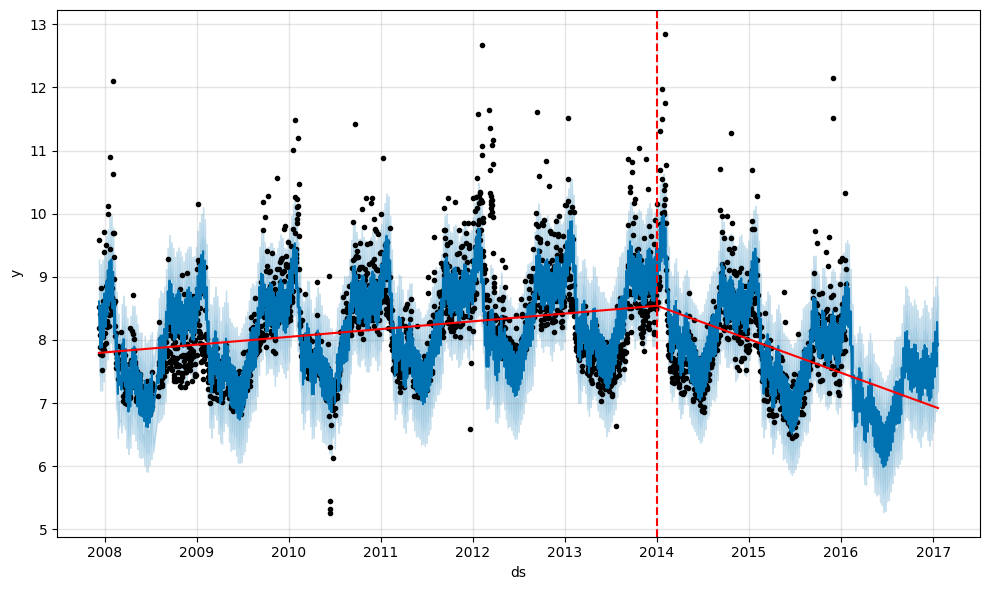

In [ ]:
model = Prophet(changepoints=[`2014-01-01`]).fit(df)
future = model.make_future_dataframe(periods=366)
forecast = model.predict(future)
fig = model.plot(forecast)
fp.add_changepoints_to_plot(fig.gca(), model, forecast);

### 例題 SP500データ

株価の予測を行う．

傾向変化点の候補は自動的に設定される。既定値では時系列の最初の80%の部分に均等に設定される。これは、モデルの**changepoint_range**引数で設定する．
この例では，期間の終わりで変化点を設定したいので，0.95に変更する．

年次の季節変動の変化の度合いは、**yearly_seasonality**（既定値は $10$) で制御できる。この例では，このパラメータを $5$ に変更することによって年間の季節変動を抑制して予測を行う．


In [ ]:
sp500 = data.sp500()
sp500.tail()

date    price
118 2009-11-01  1095.63
119 2009-12-01  1115.10
120 2010-01-01  1073.87
121 2010-02-01  1104.49
122 2010-03-01  1140.45

In [ ]:
#hide
# fig = px.line(sp500,x="date",y="price") 
# plotly.offline.plot(fig);

In [ ]:
sp500.rename(inplace=True,columns={"date":"ds","price":"y"})

11:30:30 - cmdstanpy - INFO - Chain [1] start processing
11:30:30 - cmdstanpy - INFO - Chain [1] done processing


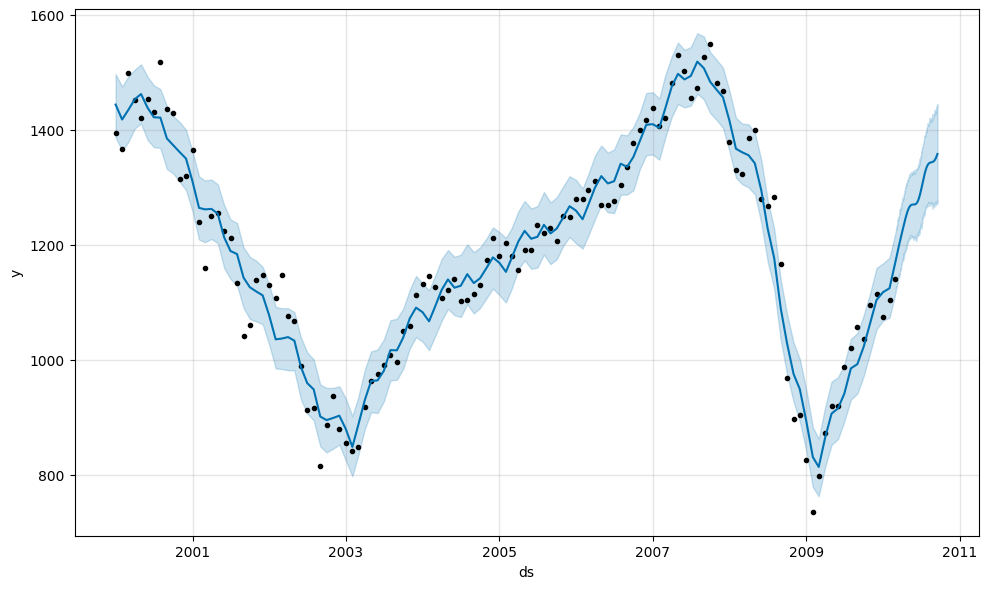

In [ ]:
model = Prophet(changepoint_prior_scale=0.5, changepoint_range=0.95,yearly_seasonality=5).fit(sp500)
future = model.make_future_dataframe(periods=200, freq=`D`)
forecast = model.predict(future)
model.plot(forecast);

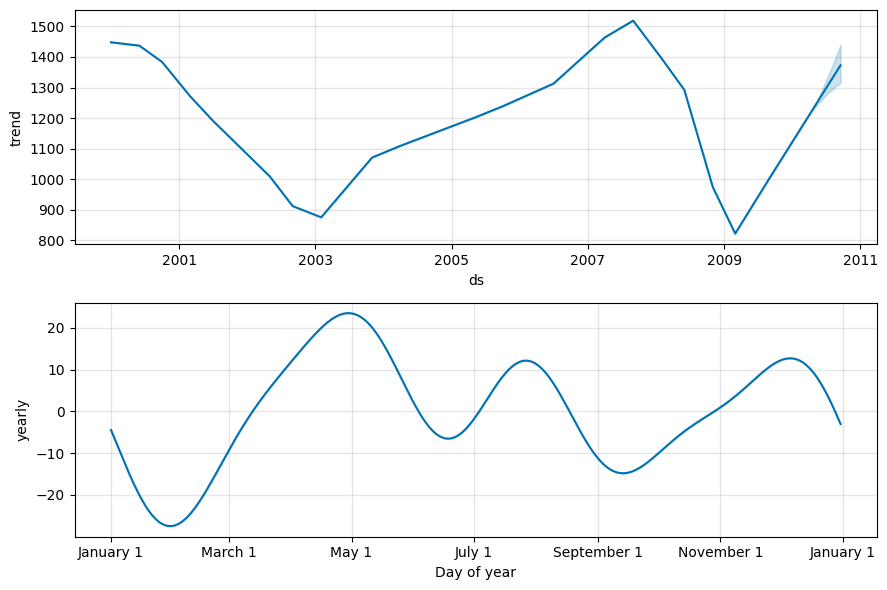

In [ ]:
model.plot_components(forecast);

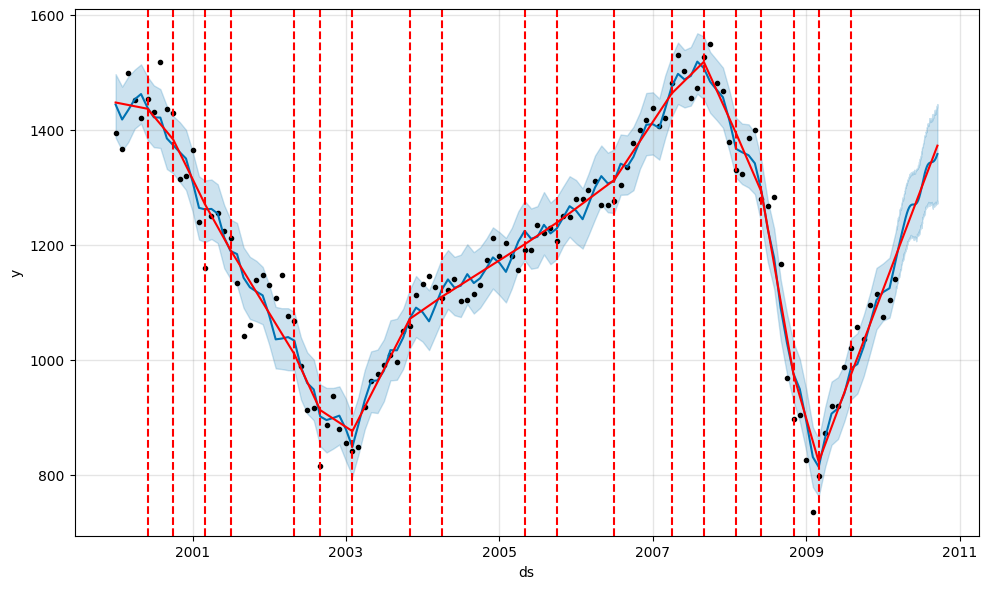

In [ ]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

### 例題： 個別銘柄の株価の予測

stocksデータでは，symbol列に企業コードが入っている．

- AAPL アップル
- AMZN アマゾン
- IBM  IBM
- GOOG グーグル
- MSFT マイクロソフト

まずは可視化を行う。

In [ ]:
stocks = data.stocks()
stocks.tail()

symbol       date   price
555   AAPL 2009-11-01  199.91
556   AAPL 2009-12-01  210.73
557   AAPL 2010-01-01  192.06
558   AAPL 2010-02-01  204.62
559   AAPL 2010-03-01  223.02

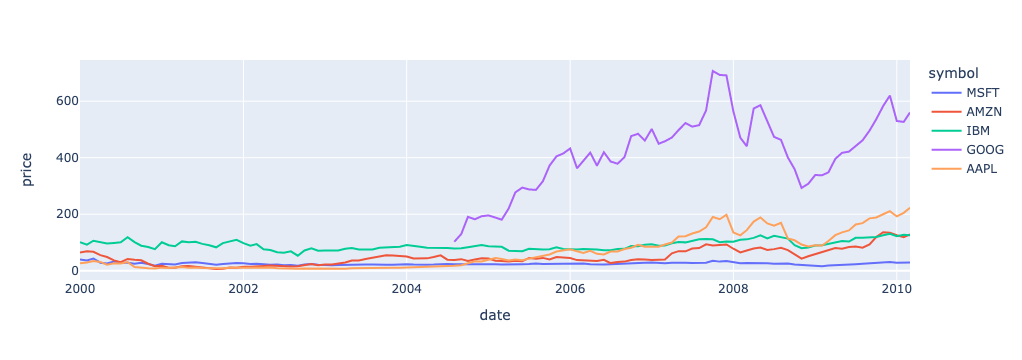

In [ ]:
fig = px.line(stocks,x="date",y="price",color="symbol")
plotly.offline.plot(fig);

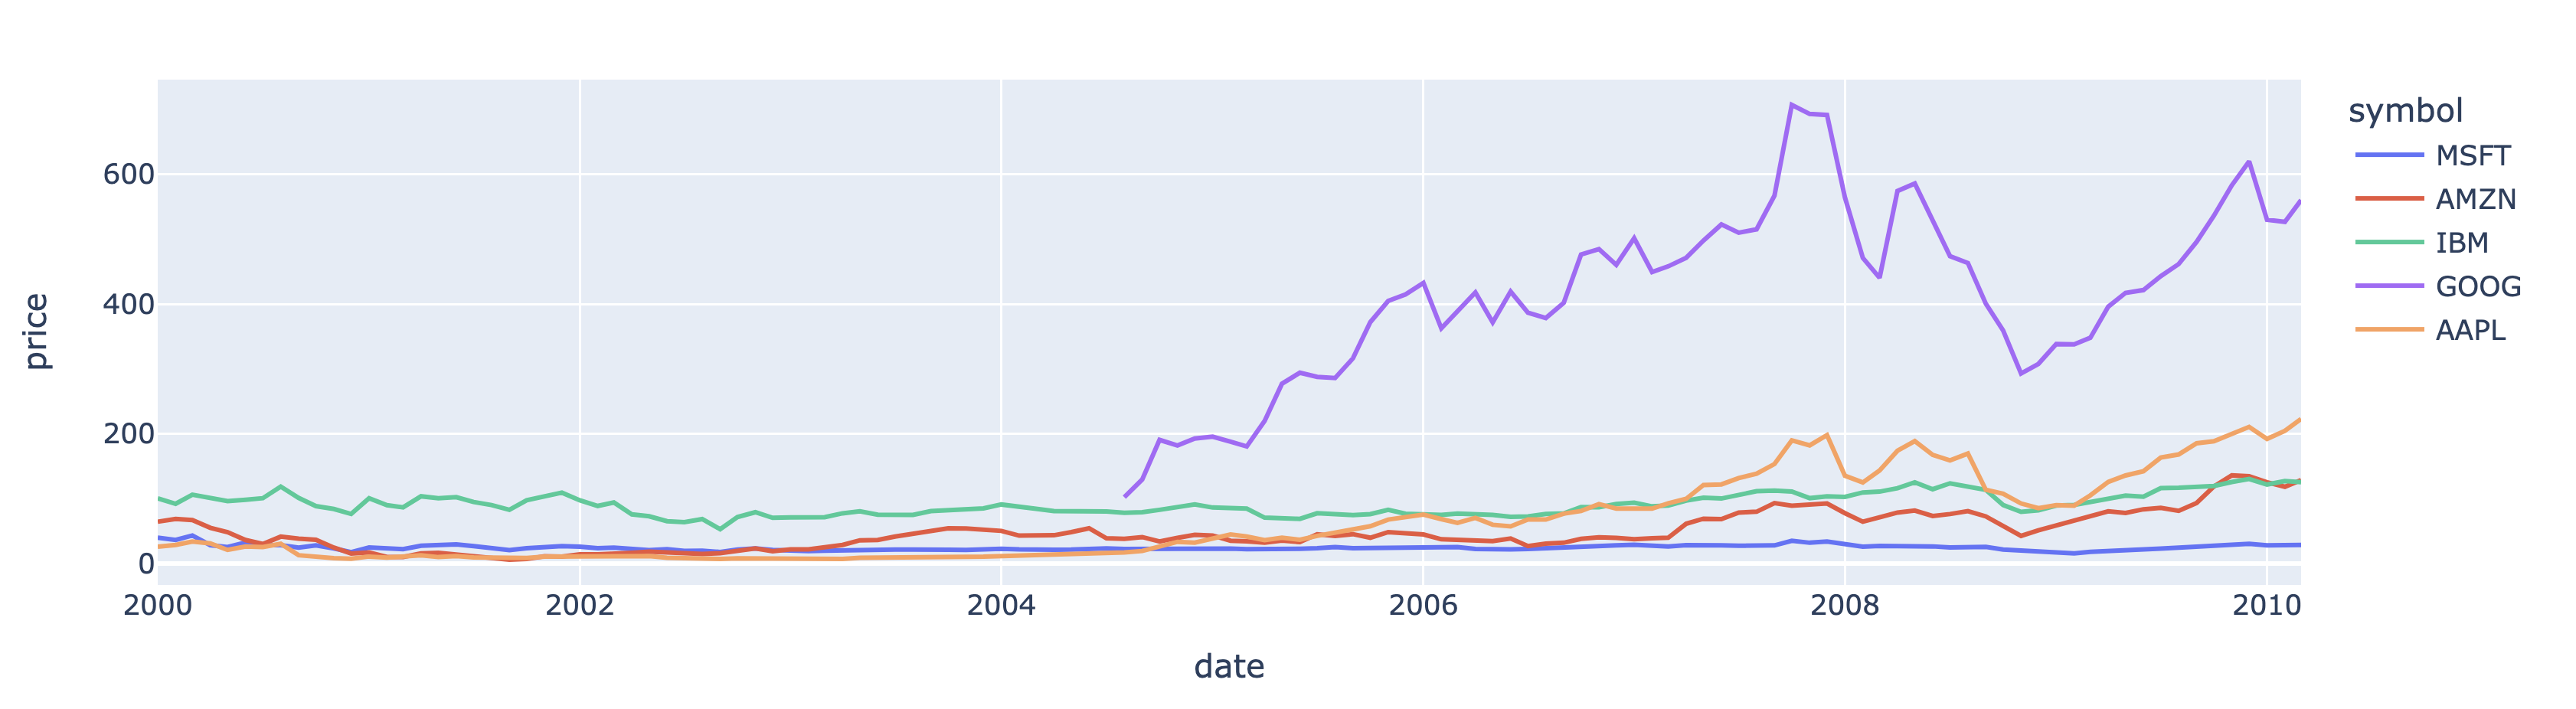

In [ ]:
# hide_input
Image("../figure/prophet5.PNG", width=700, height=400)

以下では，マイクロソフトの株価を予測してみる．

In [ ]:
msft = stocks[ stocks.symbol == "MSFT"]
msft.head()

symbol       date  price
0   MSFT 2000-01-01  39.81
1   MSFT 2000-02-01  36.35
2   MSFT 2000-03-01  43.22
3   MSFT 2000-04-01  28.37
4   MSFT 2000-05-01  25.45

In [ ]:
msft = msft.rename(columns={"date":"ds","price":"y"})
msft.head()

symbol         ds      y
0   MSFT 2000-01-01  39.81
1   MSFT 2000-02-01  36.35
2   MSFT 2000-03-01  43.22
3   MSFT 2000-04-01  28.37
4   MSFT 2000-05-01  25.45

11:33:31 - cmdstanpy - INFO - Chain [1] start processing
11:33:31 - cmdstanpy - INFO - Chain [1] done processing


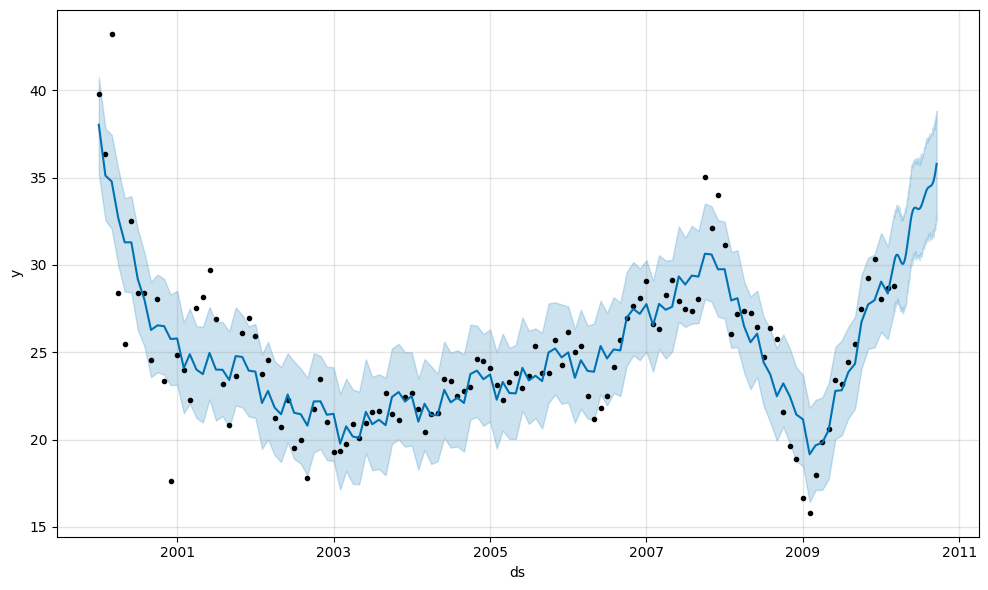

In [ ]:
model = Prophet(changepoint_prior_scale=0.5, changepoint_range=0.95,yearly_seasonality=5).fit(msft)
future = model.make_future_dataframe(periods=200, freq=`D`)
forecast = model.predict(future)
model.plot(forecast);

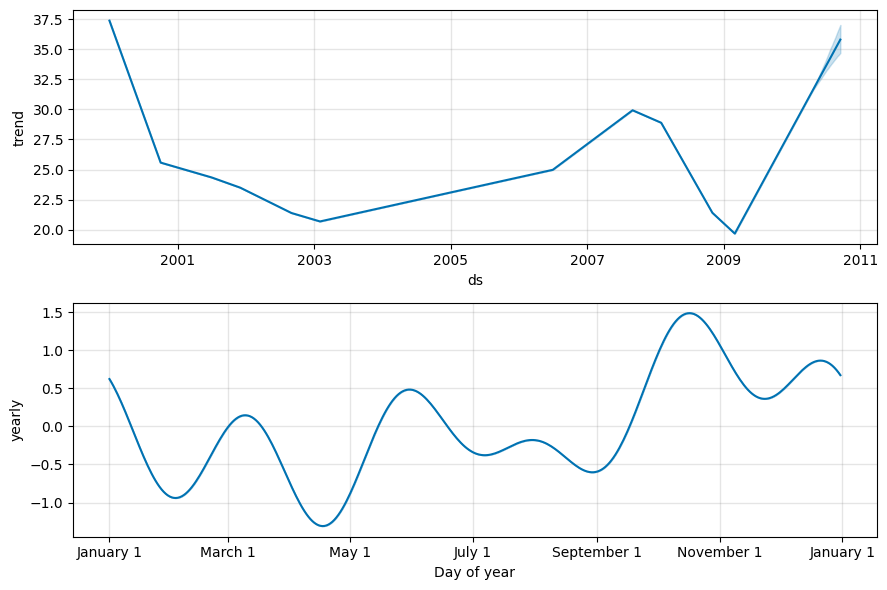

In [ ]:
model.plot_components(forecast);

### 問題（株価）

上の株価データのマイクロソフト以外の銘柄を1つ選択し，予測を行え．

In [ ]:
stocks = data.stocks()
stocks.head()

symbol       date  price
0   MSFT 2000-01-01  39.81
1   MSFT 2000-02-01  36.35
2   MSFT 2000-03-01  43.22
3   MSFT 2000-04-01  28.37
4   MSFT 2000-05-01  25.45

In [ ]:
#export
# stocks = data.stocks()
# amzn = stocks[ stocks.symbol == "AMZN"]
# amzn = amzn.rename(columns={"date":"ds","price":"y"})
# model = Prophet(changepoint_prior_scale=0.5, changepoint_range=0.95, yearly_seasonality=5).fit(amzn)
# future = model.make_future_dataframe(periods=200, freq=`D`)
# forecast = model.predict(future)
# model.plot(forecast);

## 発展編

以下では，Prophetの高度な使用法を解説する．


### ロジスティック曲線による予測

Prophetによる予測の既定値は線形モデルであるが、ロジスティック曲線を用いることもできる。これによって，上限や下限に漸近する時系列データの予測を行うことができる．

上限を規定するためには、データフレームの**cap**列に上限値（容量(capacity)の略でcap）を入力する。(下限値を設定する場合には、`floor`列に下限値を入力する.)
これは行(データ）ごとに設定しなければならない．

次いで、引数`growth`を`logistic`に設定してProphetモデルを生成すると、ロジスティック曲線に当てはめを行う。

In [ ]:
logistic = pd.read_csv("http://logopt.com/data/logistic.csv")

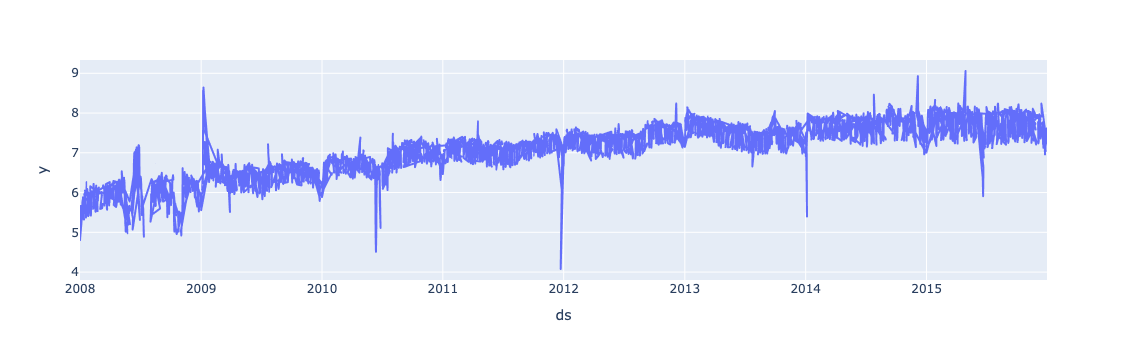

In [ ]:
#hide
fig = px.line(logistic,x="ds",y="y")
plotly.offline.plot(fig);

11:34:53 - cmdstanpy - INFO - Chain [1] start processing
11:34:53 - cmdstanpy - INFO - Chain [1] done processing


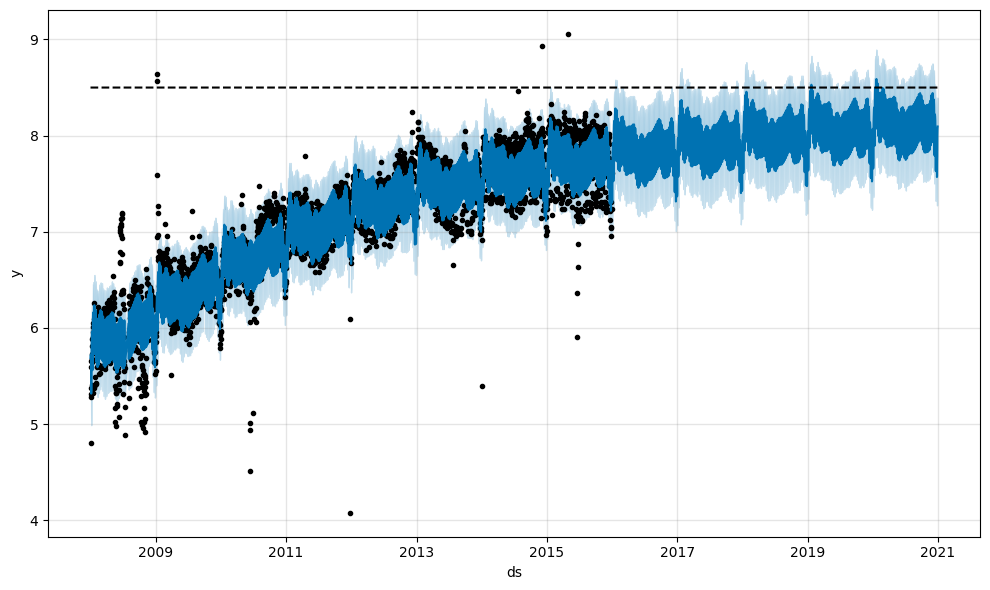

In [ ]:
model = Prophet(growth="logistic") 
logistic["cap"] = 8.5 
model.fit(logistic)    
future = model.make_future_dataframe(periods=1826)
future[`cap`] = 8.5
forecast = model.predict(future)
model.plot(forecast);                      


### 外れ値の影響

外れ値(outlier)を除去すると予測の精度が向上する場合がある。以下の例では、2010年あたりに大きな変化があるため、予測の幅が広がっている。

In [ ]:
outliers1 = pd.read_csv("http://logopt.com/data/outliers1.csv")

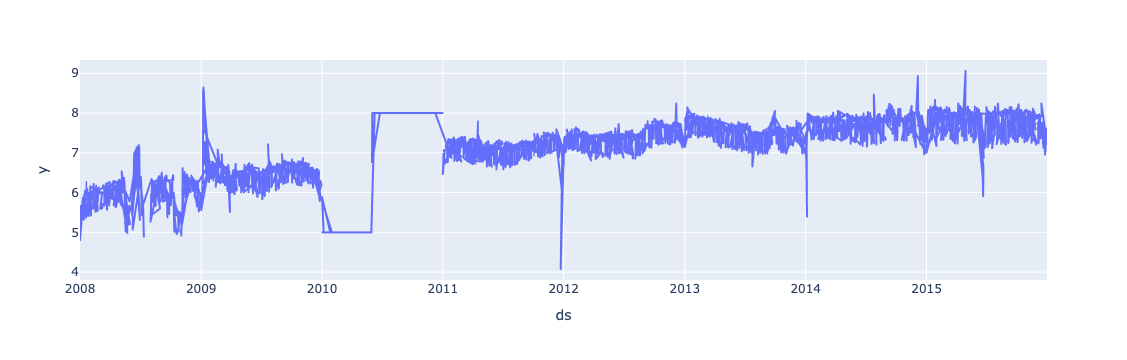

In [ ]:
#hide
fig = px.line(outliers1,x="ds",y="y")
plotly.offline.plot(fig);

11:35:45 - cmdstanpy - INFO - Chain [1] start processing
11:35:47 - cmdstanpy - INFO - Chain [1] done processing


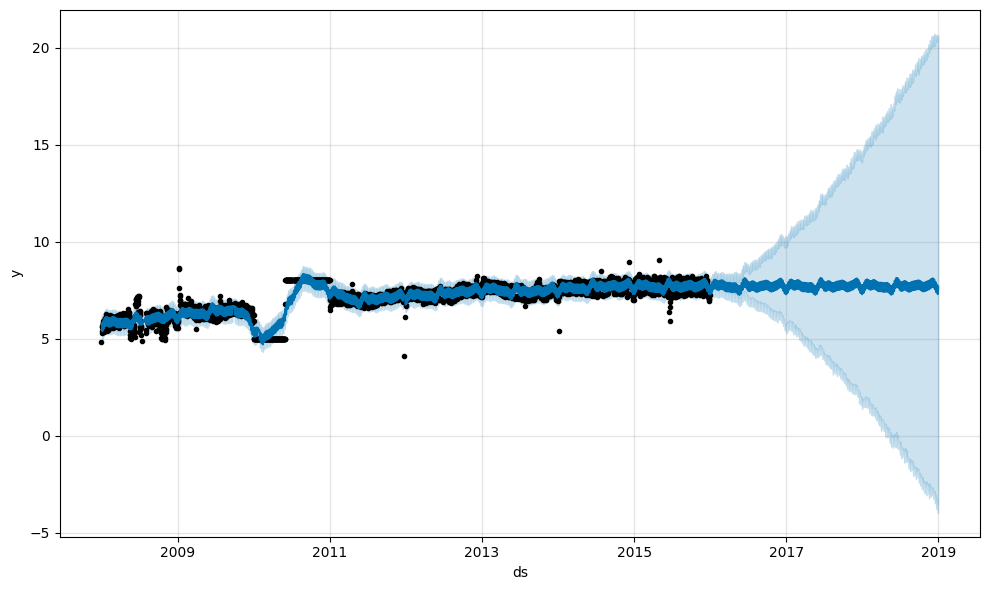

In [ ]:
model = Prophet()
model.fit(outliers1)
future = model.make_future_dataframe(periods=1096)
forecast = model.predict(future)
model.plot(forecast);

2010年のデータを除外することによって、予測が改善される。

11:35:52 - cmdstanpy - INFO - Chain [1] start processing
11:35:52 - cmdstanpy - INFO - Chain [1] done processing


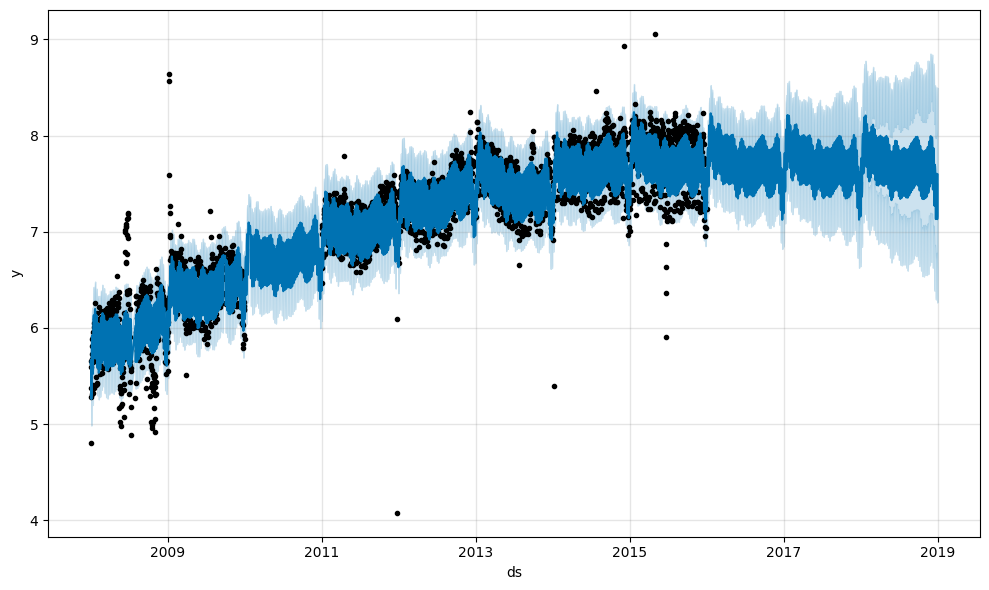

In [ ]:
outliers1.loc[(outliers1[`ds`] > `2010-01-01`) & (outliers1[`ds`] < `2011-01-01`), `y`] = None
model =Prophet()
model.fit(outliers1)
forecast = model.predict(future)
model.plot(forecast);

上では、外れ値を除外することによって予測が改善されたが、これがいつでも成立するとは限らない。以下の例では2015年6月に外れ値が観察される。　

In [ ]:
outliers2 = pd.read_csv("http://logopt.com/data/outliers2.csv")

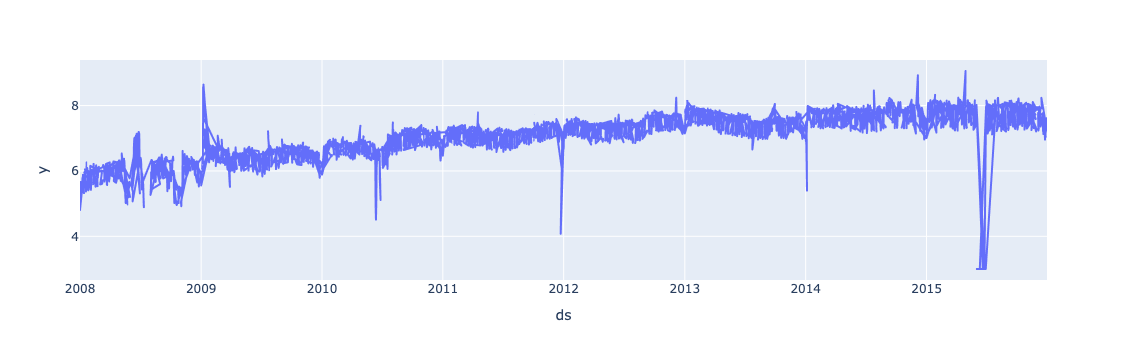

In [ ]:
#hide
fig = px.line(outliers2,x="ds",y="y")
plotly.offline.plot(fig);

11:36:21 - cmdstanpy - INFO - Chain [1] start processing
11:36:21 - cmdstanpy - INFO - Chain [1] done processing


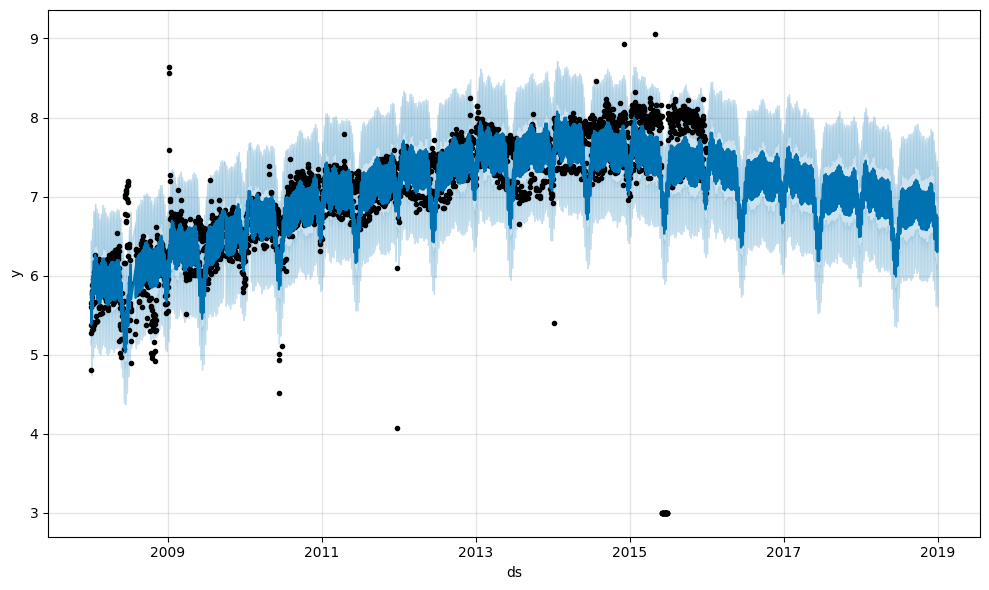

In [ ]:
model = Prophet()
model.fit(outliers2)
future = model.make_future_dataframe(periods=1096)
forecast = model.predict(future)
model.plot(forecast);

上の予測では2015年6月のデータを予測に用いず，外れ値として処理しているので，外れ値を除外すると予測の幅が広がる。

11:36:26 - cmdstanpy - INFO - Chain [1] start processing
11:36:27 - cmdstanpy - INFO - Chain [1] done processing


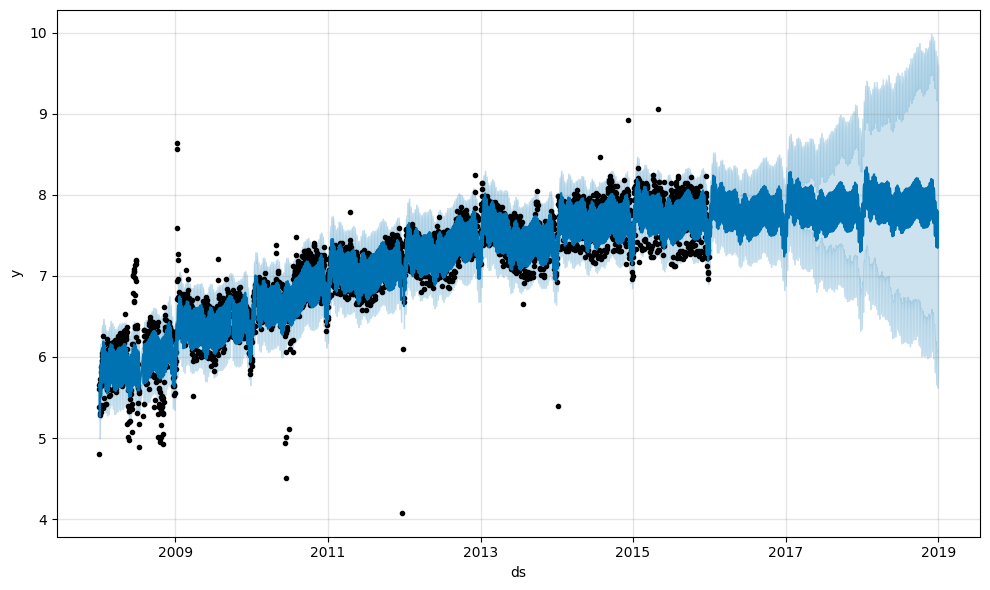

In [ ]:
outliers2.loc[(outliers2[`ds`] > `2015-06-01`) & (outliers2[`ds`] < `2015-06-30`), `y`] = None
model = Prophet()
model.fit(outliers2)
future = model.make_future_dataframe(periods=1096)
forecast = model.predict(future)
model.plot(forecast);

### 休日（特別なイベント）を考慮した予測

休日や特別なイベントをモデルに追加することを考える。そのためには、`holiday` と `ds`(datestamp)を列名としたデータフレームを準備する必要がある。`holiday`列にはイベント名を、`ds`にはそのイベントが発生する日時を入力する。

以下では、`holiday` 列に `superbowl` と `playoff` の2種類を入れる。

また、イベントの影響が指定した日時の前後何日まで影響を与えるかを示す2つの列`lower_window`と `upper_window`を追加することができる。

例としてPeyton Manningの例題のデータを用いる．

In [ ]:
df = pd.read_csv(`http://logopt.com/data/peyton_manning.csv`)
df.head()

ds         y
0  2007-12-10  9.590761
1  2007-12-11  8.519590
2  2007-12-12  8.183677
3  2007-12-13  8.072467
4  2007-12-14  7.893572

In [ ]:
playoffs = pd.DataFrame({
  `holiday`: `playoff`,
  `ds`: pd.to_datetime([`2008-01-13`, `2009-01-03`, `2010-01-16`,
                        `2010-01-24`, `2010-02-07`, `2011-01-08`,
                        `2013-01-12`, `2014-01-12`, `2014-01-19`,
                        `2014-02-02`, `2015-01-11`, `2016-01-17`,
                        `2016-01-24`, `2016-02-07`]),
  `lower_window`: 0,
  `upper_window`: 1,
})
superbowls = pd.DataFrame({
  `holiday`: `superbowl`,
  `ds`: pd.to_datetime([`2010-02-07`, `2014-02-02`, `2016-02-07`]),
  `lower_window`: 0,
  `upper_window`: 1,
})
holidays = pd.concat((playoffs, superbowls))
holidays.head()

holiday         ds  lower_window  upper_window
0  playoff 2008-01-13             0             1
1  playoff 2009-01-03             0             1
2  playoff 2010-01-16             0             1
3  playoff 2010-01-24             0             1
4  playoff 2010-02-07             0             1

引数holidaysで休日を表すデータフレームを与えることによって、特別なイベントを考慮した予測を行うことができる。

In [ ]:
model= Prophet(holidays=holidays)
model.fit(df)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

11:37:41 - cmdstanpy - INFO - Chain [1] start processing
11:37:42 - cmdstanpy - INFO - Chain [1] done processing


プレーオフやスーパーボールなどのイベント効果がある日だけ抜き出してデータフレームを表示する．

In [ ]:
forecast[(forecast[`playoff`] + forecast[`superbowl`]).abs() > 0][
        [`ds`, `playoff`, `superbowl`]][-10:]

ds   playoff  superbowl
2190 2014-02-02  1.231269   1.189638
2191 2014-02-03  1.900381   1.461279
2532 2015-01-11  1.231269   0.000000
2533 2015-01-12  1.900381   0.000000
2901 2016-01-17  1.231269   0.000000
2902 2016-01-18  1.900381   0.000000
2908 2016-01-24  1.231269   0.000000
2909 2016-01-25  1.900381   0.000000
2922 2016-02-07  1.231269   1.189638
2923 2016-02-08  1.900381   1.461279

因子別に描画を行うと，イベントによって変化した量が描画される（上から2番目）．

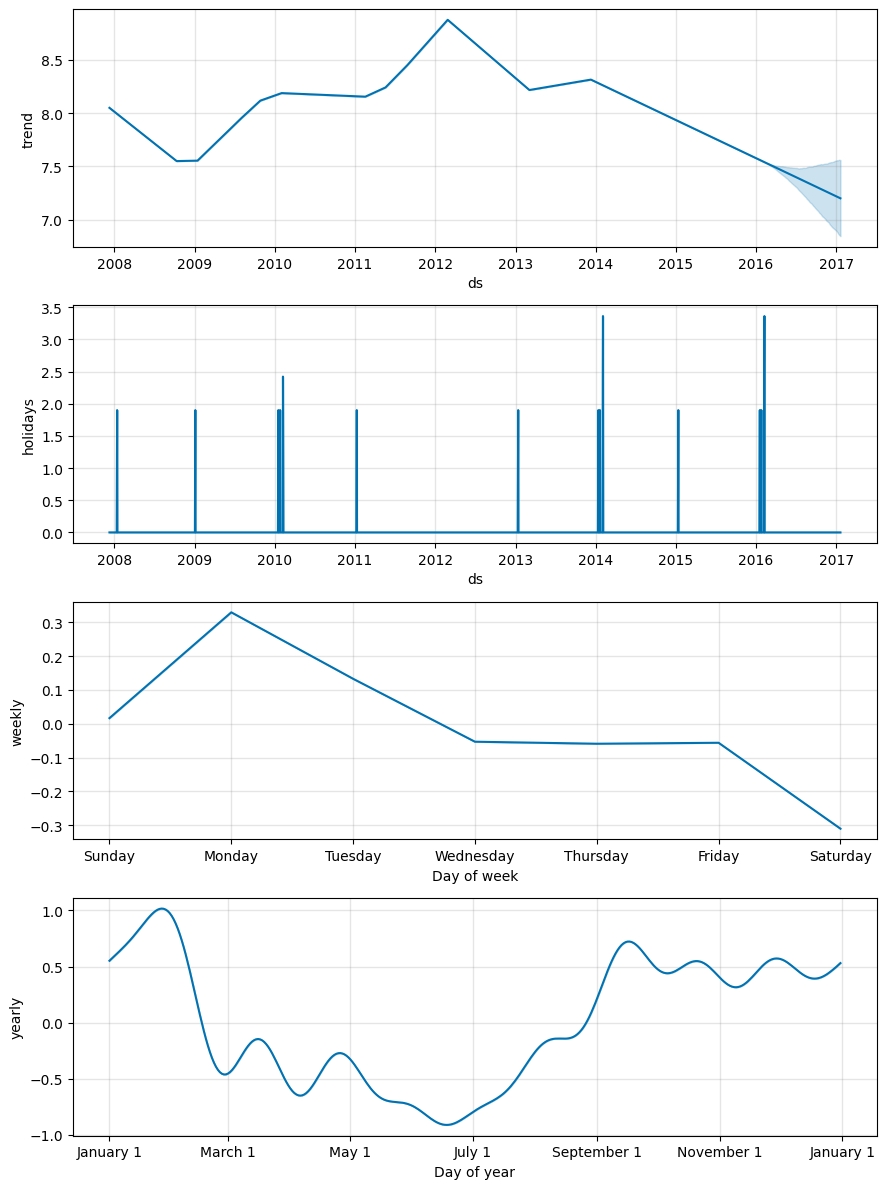

In [ ]:
model.plot_components(forecast);


### 国（州）別の休日

`add_country_holidays`を用いて，各国（州）の休日データを追加することができる。日本のデータもあるが、天皇誕生日がずれていたりするので、注意を要する。

In [ ]:
model = Prophet(holidays=holidays)
model.add_country_holidays(country_name=`US`)
model.fit(df)

11:38:05 - cmdstanpy - INFO - Chain [1] start processing
11:38:05 - cmdstanpy - INFO - Chain [1] done processing


<prophet.forecaster.Prophet>

追加された休日名を**train_holiday_names**属性で確認しておく．

In [ ]:
model.train_holiday_names

0                         playoff
1                       superbowl
2                  New Year's Day
3      Martin Luther King Jr. Day
4           Washington's Birthday
5                    Memorial Day
6                Independence Day
7                       Labor Day
8                    Columbus Day
9                    Veterans Day
10                   Thanksgiving
11                  Christmas Day
12       Christmas Day (Observed)
13        Veterans Day (Observed)
14    Independence Day (Observed)
15      New Year's Day (Observed)
dtype: object

米国の休日を考慮して予測を行い，因子別に描画してみる．上から2番目が，休日に対する影響を表している．

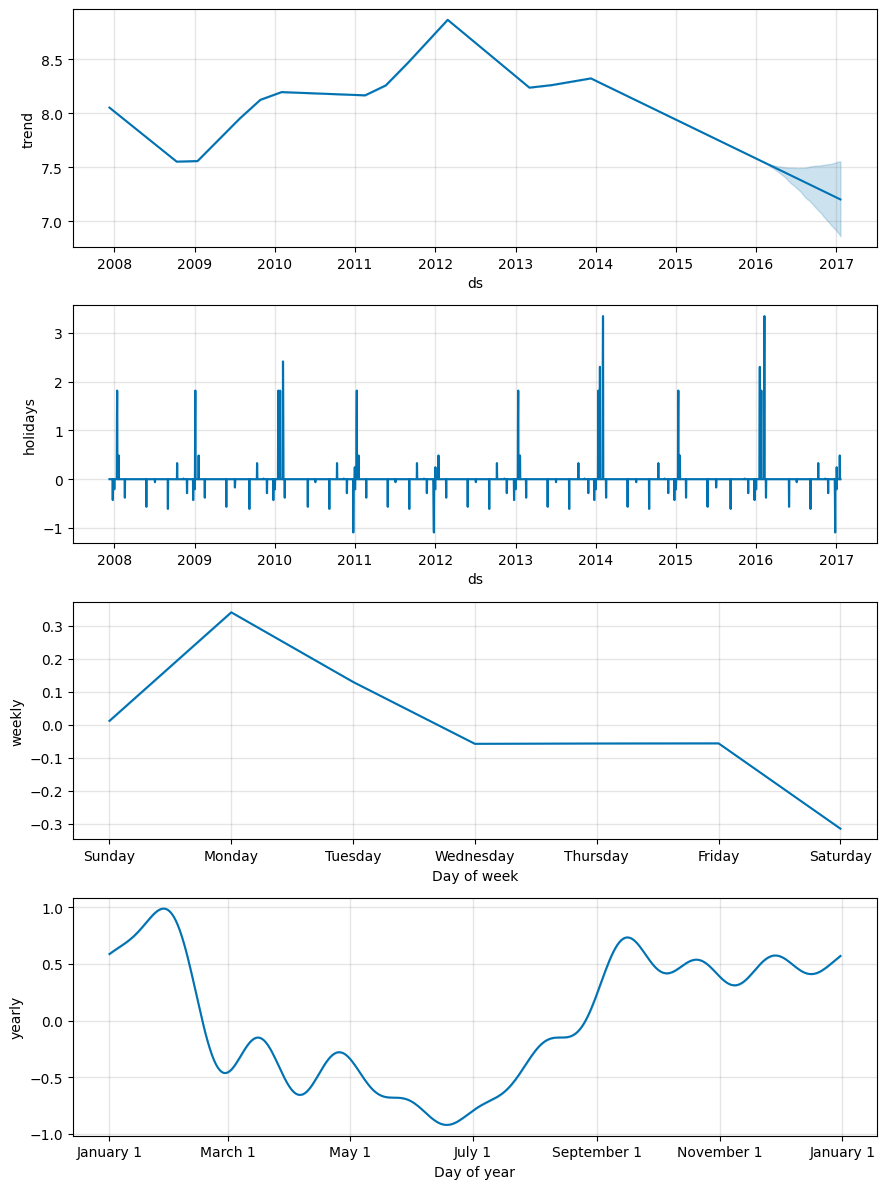

In [ ]:
forecast = model.predict(future)
model.plot_components(forecast);

### 予測因子の追加

`add_regressor`メソッドを用いると、モデルに因子を追加できる。以下の例では、オンシーズンの日曜日にだけ影響がでる因子を追加している。

11:38:22 - cmdstanpy - INFO - Chain [1] start processing
11:38:22 - cmdstanpy - INFO - Chain [1] done processing


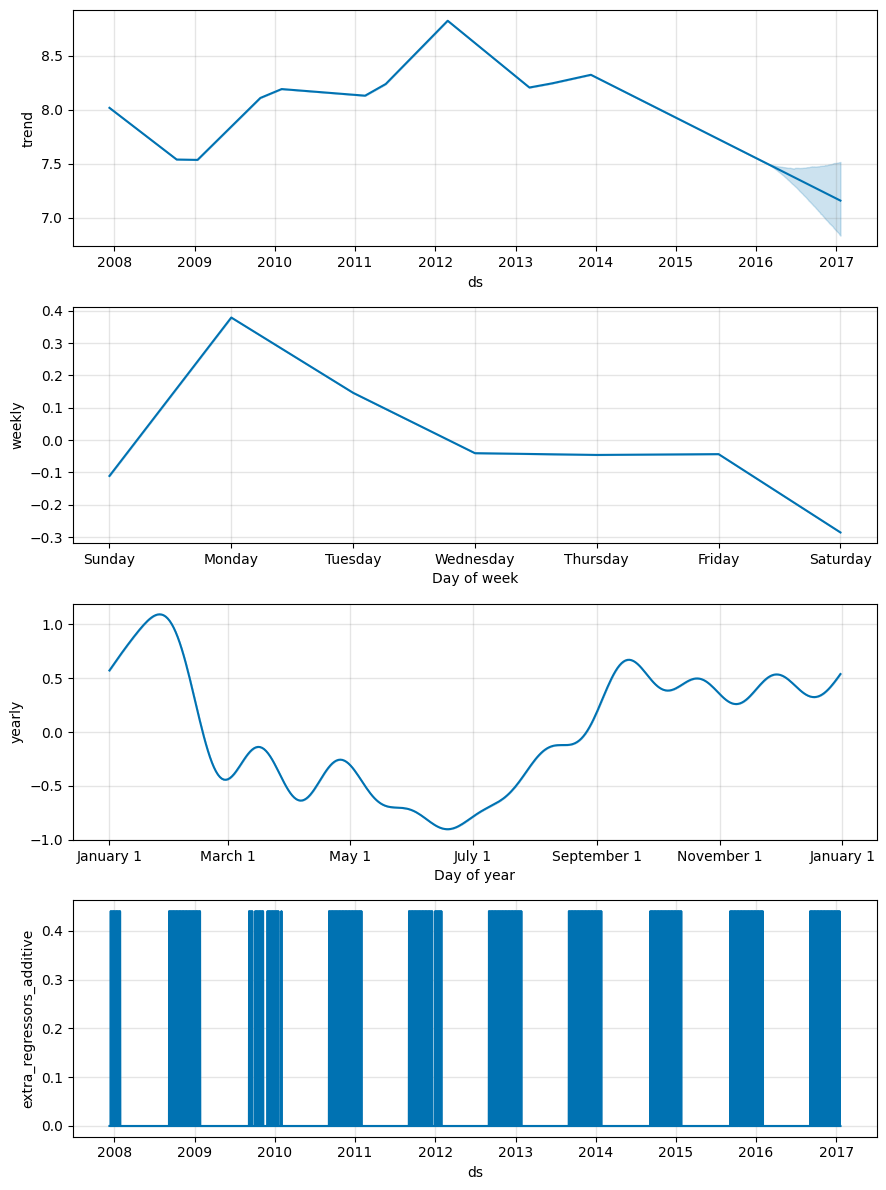

In [ ]:
 def nfl_sunday(ds):
   date = pd.to_datetime(ds)
   if date.weekday() == 6 and (date.month > 8 or date.month < 2):
     return 1
   else:
     return 0
df = pd.read_csv(`http://logopt.com/data/peyton_manning.csv`)
df[`nfl_sunday`] = df[`ds`].apply(nfl_sunday)
model = Prophet()
model.add_regressor(`nfl_sunday`)
model.fit(df)
future = model.make_future_dataframe(periods=365)
future[`nfl_sunday`] = future[`ds`].apply(nfl_sunday)
forecast = model.predict(future)
model.plot_components(forecast); 

### ユーザーが設定した季節変動

Prophetでは既定値の年次や週次の季節変動だけでなく、ユーザー自身で季節変動を定義・追加できる。以下では、週次の季節変動を除き，かわりに周期が30.5日の月次変動をフーリエ次数（seasonalityの別名）5として追加している。

11:38:38 - cmdstanpy - INFO - Chain [1] start processing
11:38:38 - cmdstanpy - INFO - Chain [1] done processing


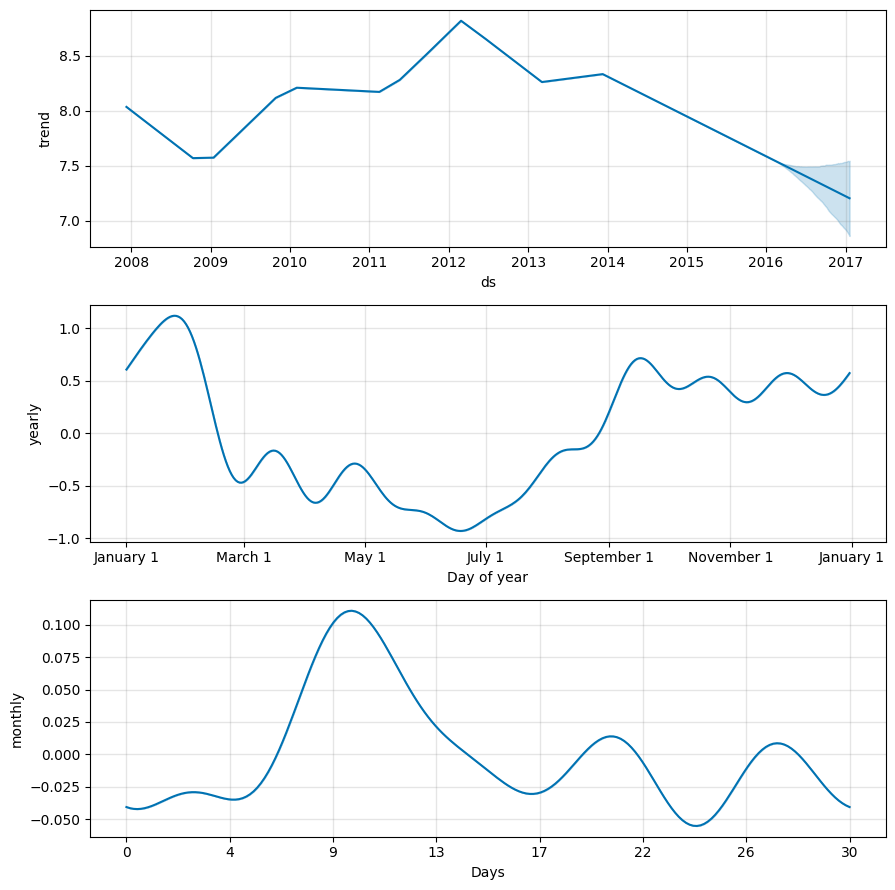

In [ ]:
model = Prophet(weekly_seasonality=False)
model.add_seasonality(name=`monthly`, period=30.5, fourier_order=5)
model.fit(df)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)
model.plot_components(forecast);

### 他の要因に依存した季節変動

他の要因に依存した季節変動も定義・追加することができる。以下の例では、オンシーズンとオフシーズンごと週次変動を定義し、追加してみる。

In [ ]:
def is_nfl_season(ds):
    date = pd.to_datetime(ds)
    return (date.month > 8 or date.month < 2)
df[`on_season`] = df[`ds`].apply(is_nfl_season)
df[`off_season`] = ~df[`ds`].apply(is_nfl_season)

11:38:48 - cmdstanpy - INFO - Chain [1] start processing
11:38:49 - cmdstanpy - INFO - Chain [1] done processing


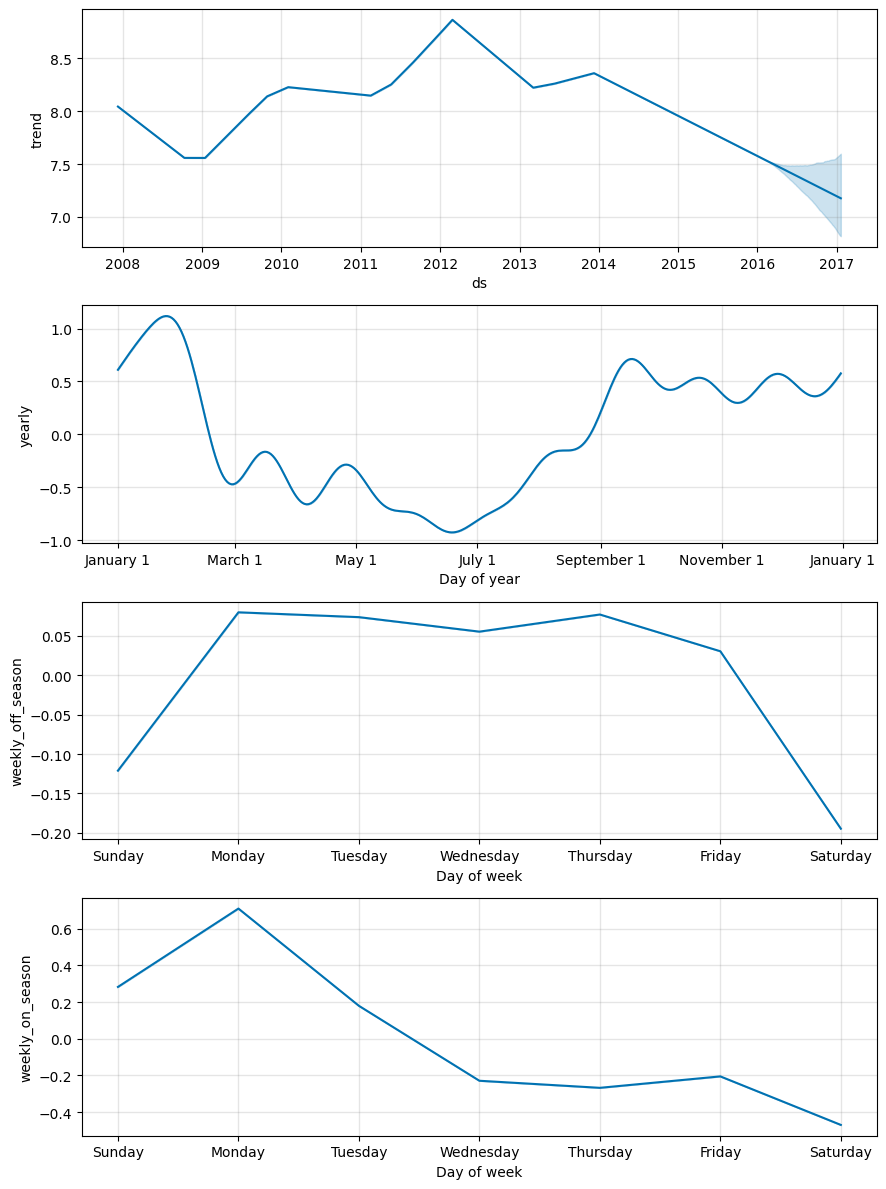

In [ ]:
model = Prophet(weekly_seasonality=False)
model.add_seasonality(name=`weekly_on_season`, period=7, fourier_order=3, condition_name=`on_season`)
model.add_seasonality(name=`weekly_off_season`, period=7, fourier_order=3, condition_name=`off_season`)
model.fit(df)
future = model.make_future_dataframe(periods=365)
future[`on_season`] = future[`ds`].apply(is_nfl_season)
future[`off_season`] = ~future[`ds`].apply(is_nfl_season)
forecast =model.predict(future)
model.plot_components(forecast);

### 休日と季節変動の効果の調整法

休日の影響を抑制するためには、`holidays_prior_scale`を小さくすれば良い。このパラメータの既定値は $10$ であり、これはほとんど正則化を行わないことを意味する。
一般に， `prior_scale` を大きくするとそのパラメータの柔軟性が増し，小さくすると柔軟性が減る．以下では，`holidays_prior_scale`を $0.05$ に設定して予測を行う．

In [ ]:
df = pd.read_csv(`http://logopt.com/data/peyton_manning.csv`)
model= Prophet(holidays=holidays, holidays_prior_scale=0.05)
model.fit(df)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

forecast[(forecast[`playoff`] + forecast[`superbowl`]).abs() > 0][
    [`ds`, `playoff`, `superbowl`]][-10:]

11:39:23 - cmdstanpy - INFO - Chain [1] start processing
11:39:24 - cmdstanpy - INFO - Chain [1] done processing


ds   playoff  superbowl
2190 2014-02-02  1.203527   0.970955
2191 2014-02-03  1.851203   0.993308
2532 2015-01-11  1.203527   0.000000
2533 2015-01-12  1.851203   0.000000
2901 2016-01-17  1.203527   0.000000
2902 2016-01-18  1.851203   0.000000
2908 2016-01-24  1.203527   0.000000
2909 2016-01-25  1.851203   0.000000
2922 2016-02-07  1.203527   0.970955
2923 2016-02-08  1.851203   0.993308

スーパーボール（superbowl）の効果が抑制されていることが見てとれる．
同様に，季節変動の影響は`seasonality_prior_scale`を小さくすることによって抑制できる。


### 不確実性の幅

Prophetは既定では傾向変動に対する不確実性の幅を予測する。このとき、引数`interval_width`で予測の幅を設定できる。既定値は $0.8$ である。このパラメータを大きくすると幅が広がり、小さくすると幅が狭くなることが確認できる。

例として $CO_2$ 排出量のデータを用いる．

In [ ]:
co2 = data.co2_concentration()
co2.rename(columns={"Date":"ds","CO2":"y"},inplace=True)
co2.head()

ds       y
0  1958-03-01  315.70
1  1958-04-01  317.46
2  1958-05-01  317.51
3  1958-07-01  315.86
4  1958-08-01  314.93

11:39:35 - cmdstanpy - INFO - Chain [1] start processing
11:39:35 - cmdstanpy - INFO - Chain [1] done processing


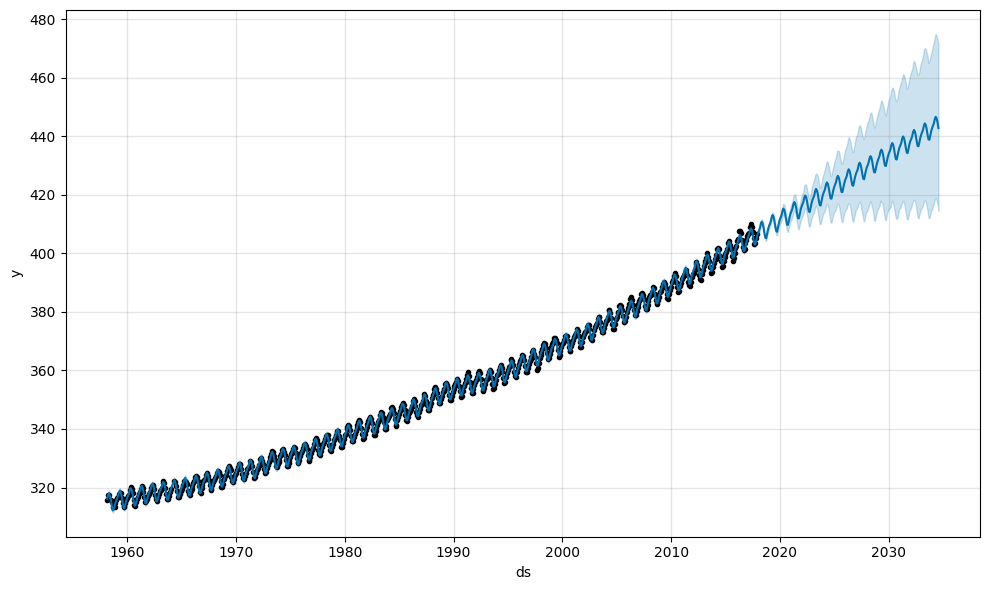

In [ ]:
model = Prophet(interval_width=0.95)
model.fit(co2)
future = model.make_future_dataframe(periods=200, freq=`M`)
forecast = model.predict(future)
model.plot(forecast);

11:39:37 - cmdstanpy - INFO - Chain [1] start processing
11:39:37 - cmdstanpy - INFO - Chain [1] done processing


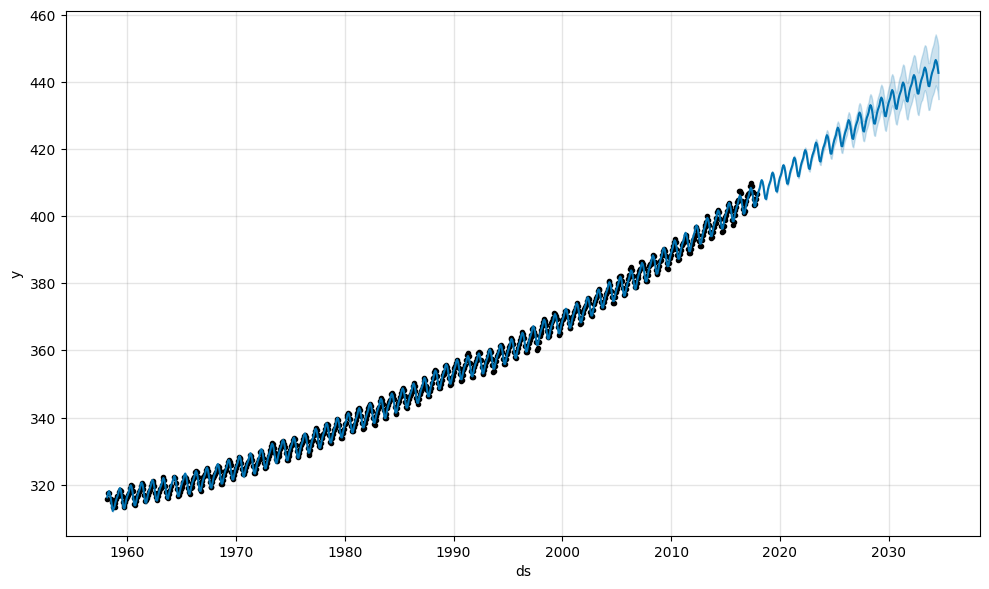

In [ ]:
forecast = Prophet(interval_width=0.5).fit(co2).predict(future)
model.plot(forecast);

季節変動に対する不確実性を予測するためには、マルコフ連鎖モンテカルロ法を行う必要がある、そのためには、引数 `mcmc_samples` をシミュレーションの反復回数に設定する。
このパラメータの既定値は $0$ である。

これによって、既定値の最大事後確率（MAP）推定の代わりにマルコフ連鎖モンテカルロ法によるサンプリングが行われる。これは、非常に時間がかかることもある。 要因別に図を描画してみると、季節変動に対しても不確実性の幅が示されていることが確認できる。

11:41:11 - cmdstanpy - INFO - CmdStan installation /Users/mikiokubo/Library/Caches/pypoetry/virtualenvs/analytics-v-sH3Dza-py3.8/lib/python3.8/site-packages/prophet/stan_model/cmdstan-2.26.1 missing makefile, cannot get version.
11:41:11 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
11:41:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:41:18 - cmdstanpy - INFO - CmdStan done processing.
11:41:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in '/Users/runner/work/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in '/Users/runner/work/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/Users/runner/work/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in '/Users/runner/work/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finit

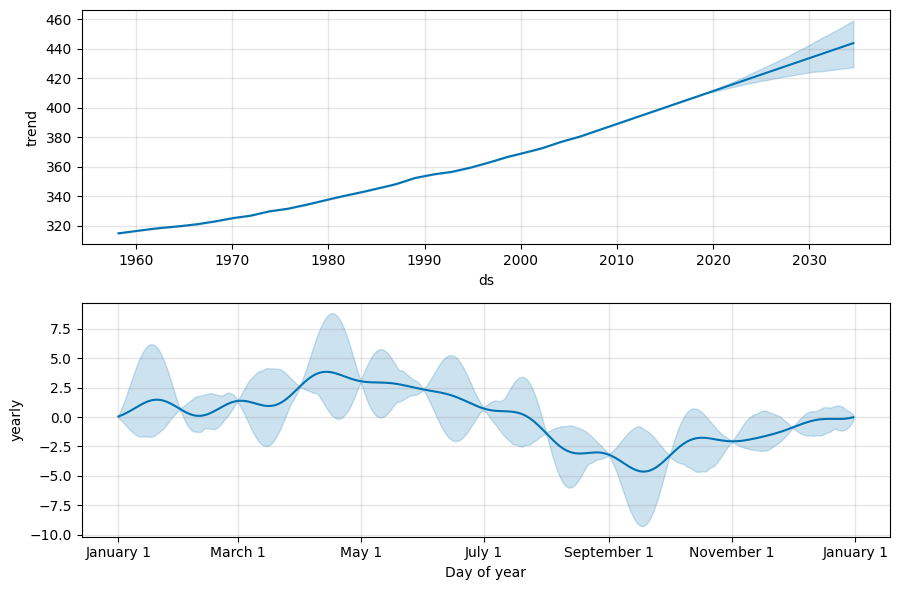

In [ ]:
model = Prophet(mcmc_samples=100)
forecast = model.fit(co2).predict(future)
model.plot_components(forecast);

### 検証と誤差の評価

Prophetでは、予測の精度を検証するための仕組みが組み込まれている。例として、Peyton Manningのデータセットを用いる。
このデータセットは、全部で $2905$ 日分のデータで構成されている。

交差検証のためには`cross_validation`を用いる。

引数は以下の通り．


- model: 予測を行うモデル；事前にfitメソッドで学習しておく必要がある．
- horizon : 計画期間（予測を行う期間）
- period : 予測の間隔；省略するとhorizonの半分が代入される．
- initial : 交差検証を開始する最初の期；省略するとhorizonの3倍が代入される．


以下の例では、initialが $730$ 日なので、$729$ 日までの情報を用いて、その後の $365$(horizon)日の予測を行い、本当の値との誤差を評価し、
次いで $730+180$(period)日までの情報を用いて、その後の $365$ 日の予測を行い評価し、という手順を最後の日まで繰り返す。
$(2905-730-365)/180 = 10.05$ であるので、 $11$ 回の予測を行い評価することになる。cross_validationは、交差検証用のデータフレームを返す。

最初の検証は $730$ 日後である 2010-2-15(cutoff)までのデータを用いて，2010-2-16から $365$ (horizon)日分の予測で行われ、次の検証はその $180$(period)日後である2010-08-14日から行われる。最後の検証は2015-01-20日までのデータを用いて2016-01-20日まで行われる。

In [ ]:
df = pd.read_csv(`http://logopt.com/data/peyton_manning.csv`)
model = Prophet()
model.fit(df);

11:43:07 - cmdstanpy - INFO - Chain [1] start processing
11:43:08 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial=`730 days`, period=`180 days`, horizon = `365 days`)
df_cv.head()

  0%|          | 0/11 [00:00<?, ?it/s]

11:43:17 - cmdstanpy - INFO - Chain [1] start processing
11:43:17 - cmdstanpy - INFO - Chain [1] done processing
11:43:17 - cmdstanpy - INFO - Chain [1] start processing
11:43:17 - cmdstanpy - INFO - Chain [1] done processing
11:43:18 - cmdstanpy - INFO - Chain [1] start processing
11:43:18 - cmdstanpy - INFO - Chain [1] done processing
11:43:19 - cmdstanpy - INFO - Chain [1] start processing
11:43:19 - cmdstanpy - INFO - Chain [1] done processing
11:43:19 - cmdstanpy - INFO - Chain [1] start processing
11:43:19 - cmdstanpy - INFO - Chain [1] done processing
11:43:20 - cmdstanpy - INFO - Chain [1] start processing
11:43:20 - cmdstanpy - INFO - Chain [1] done processing
11:43:20 - cmdstanpy - INFO - Chain [1] start processing
11:43:21 - cmdstanpy - INFO - Chain [1] done processing
11:43:21 - cmdstanpy - INFO - Chain [1] start processing
11:43:21 - cmdstanpy - INFO - Chain [1] done processing
11:43:22 - cmdstanpy - INFO - Chain [1] start processing
11:43:22 - cmdstanpy - INFO - Chain [1]

ds      yhat  yhat_lower  yhat_upper         y     cutoff
0 2010-02-16  8.959074    8.490492    9.469220  8.242493 2010-02-15
1 2010-02-17  8.725548    8.253267    9.210082  8.008033 2010-02-15
2 2010-02-18  8.609390    8.144968    9.107764  8.045268 2010-02-15
3 2010-02-19  8.531294    8.014229    9.048185  7.928766 2010-02-15
4 2010-02-20  8.273357    7.775097    8.779778  7.745003 2010-02-15

`performance_metrics` を用いてメトリクス（評価尺度）を計算する。評価尺度は、 平均平方誤差(mean squared error: MSE), 平均平方誤差の平方根 (root mean squared error: RMSE), 平均絶対誤差 (mean absolute error: MAE), 平均絶対パーセント誤差 (mean absolute percent error : MAPE),  `yhat_lower` と`yhat_upper` の間に入っている割合（被覆率: coverage) である。
 
 既定値では予測期間の最初の$10$%は除外して示される。これは、引数`rolling_window` によって変更できる。

In [ ]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv, rolling_window=0.1)
df_p.head()

horizon       mse      rmse       mae      mape     mdape     smape  \
0 37 days  0.494752  0.703386  0.505215  0.058538  0.049584  0.058826   
1 38 days  0.500521  0.707475  0.510201  0.059115  0.049373  0.059463   
2 39 days  0.522712  0.722988  0.516284  0.059713  0.049505  0.060187   
3 40 days  0.529990  0.728004  0.519131  0.060018  0.049231  0.060561   
4 41 days  0.537478  0.733129  0.520118  0.060096  0.049373  0.060702   

   coverage  
0  0.677935  
1  0.675423  
2  0.672682  
3  0.673824  
4  0.681361

評価尺度は plot_cross_validation_metricで可視化できる。以下では平均絶対パーセント誤差(MAPE)を描画している．

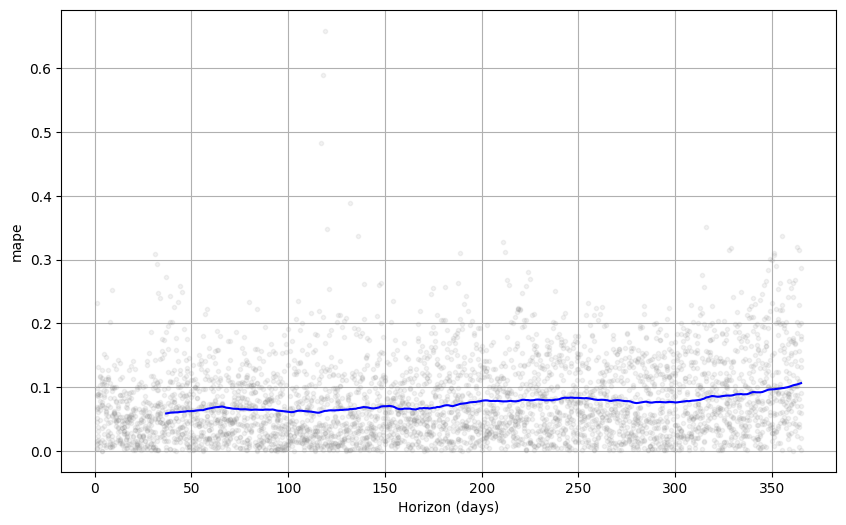

In [ ]:
from prophet.plot import plot_cross_validation_metric
plot_cross_validation_metric(df_cv, metric=`mape`);


## 主なパラメータと既定値

以下にProphetの主要なパラメータ（引数）とその既定値を示す．

- growth=`linear` :傾向変動の関数．既定値は線形．ロジスティック曲線にするには`logistic`に設定
- changepoints=None :  傾向変更点のリスト
- changepoint_range = $0.8$ : 傾向変化点の候補の幅（先頭から何割を候補とするか）
- n_changepoints=25 : 傾向変更点の数
- yearly_seasonality=`auto` :  年次の季節変動を考慮するか否か
- weekly_seasonality=`auto` : 週次の季節変動を考慮するか否か
- daily_seasonality=`auto` : 日次の季節変動を考慮するか否か
- holidays=None : 休日のリスト
- seasonality_prior_scale= $10.0$ : 季節変動の事前分布のスケール値（パラメータの柔軟性を表す）
- holidays_prior_scale= $10.0$ : 休日のの事前分布のスケール値（パラメータの柔軟性を表す）
- changepoint_prior_scale= $0.05$ :  傾向変更点の事前分布のスケール値（パラメータの柔軟性を表す）
- mcmc_samples= $0$ : MCMC法のサンプル数
- interval_width= $0.8$ : 不確実性の幅 
- uncertainty_samples= $1000$ : 不確実性の幅を計算する際のサンプル数
